In [1]:
%config Completer.use_jedi = False
import sys
import warnings
warnings.filterwarnings('ignore')

import os
os.environ["LD_LIBRARY_PATH"]="/local/cuda-10.2/lib64"
sys.path.append("/local/cuda-10.2/bin")


import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import time
import threading
import gc
import copy
import pandas as pd

sys.path.append("/end/home/rh2310/morpho_repo/turing_codebase")
from turing.utils import *
import turing.pinns as tu
from turing.loss_functions import *
from turing.pinns_experimental import TINN_masked, TINN_multi_nodes_masked



# GPU = True
# import os

# if GPU:
#     txt_device = 'gpu:0'
# else:
#     txt_device = 'cpu:0'    
#     os.environ["CUDA_VISIBLE_DEVICES"]="-1"

2022-07-21 09:11:24.670017: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2022-07-21 09:11:36.064312: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2022-07-21 09:11:36.082346: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:2d:00.0 name: Quadro RTX 6000 computeCapability: 7.5
coreClock: 1.77GHz coreCount: 72 deviceMemorySize: 23.65GiB deviceMemoryBandwidth: 625.94GiB/s
2022-07-21 09:11:36.082390: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2022-07-21 09:11:36.086318: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10
2022-07-21 09:11:36.090685: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcufft.so.10

In [2]:
def plot_result(results, start=0, end=-1, node_names=["u", "v"], yscale="log", y_lims=None):
    import matplotlib.pyplot as plt

    def _closing_commands_():
        plt.legend()
        plt.grid()
        plt.xlabel("Iterations")
        plt.yscale(yscale)
        if y_lims is not None:
            plt.ylim(y_lims)
        plt.show()

    _ = plt.figure(figsize=(14, 5))
    plt.title("Training accuracy for observations")
    plt.plot(results["training_obs_accuracy"][start:end], label="accuracy")
    _closing_commands_()

    if np.any([True if k.startswith("loss_") else False for k in results.keys()]):
        _ = plt.figure(figsize=(14, 5))
        plt.title("Real Loss")
        plt.plot(results["loss_total"][start:end], label="total")
        for i, name in enumerate(node_names):
            plt.plot(results[f"loss_obs"][start:end, i], label=f"Obs {name}")
        for i, name in enumerate(node_names):
            plt.plot(results[f"loss_pde"][start:end, i], label=f"PDE {name}")
        for key in [k for k in results.keys() if k.startswith("loss_extra_")]:
            plt.plot(results[key][start:end], label=f"{key}")

        _closing_commands_()

    if np.any([True if k.startswith("loss_") else False for k in results.keys()]):
        _ = plt.figure(figsize=(14, 5))
        plt.title("Regularisd Loss")
        plt.plot(results["loss_regularisd_total"][start:end], label="total")
        if np.any([True if k.startswith("lambda_") else False for k in results.keys()]):
            for i, name in enumerate(node_names):
                plt.plot(
                    results[f"lambda_obs"][start:end, i] * results[f"loss_obs"][start:end, i],
                    label=f"Obs {name}",
                )
            for i, name in enumerate(node_names):
                plt.plot(
                    results[f"lambda_pde"][start:end, i] * results[f"loss_pde"][start:end, i],
                    label=f"PDE {name}",
                )
        _closing_commands_()

    if np.any([True if k.startswith("grads_") else False for k in results.keys()]):
        _ = plt.figure(figsize=(14, 5))
        plt.title("Gradient Norms")
        for i, name in enumerate(node_names):
            plt.plot(results[f"grads_obs"][start:end, i], label=f"Grad obs {name}")
        for i, name in enumerate(node_names):
            plt.plot(results[f"grads_pde"][start:end, i], label=f"Grad PDE {name}")
        _closing_commands_()

    if np.any([True if k.startswith("lambda_") else False for k in results.keys()]):
        _ = plt.figure(figsize=(14, 5))
        plt.title(r"$\lambda$s")
        for i, name in enumerate(node_names):
            plt.plot(results[f"lambda_obs"][start:end, i], label=r"$\lambda$" f" obs {name}")
        for i, name in enumerate(node_names):
            plt.plot(results[f"lambda_pde"][start:end, i], label=r"$\lambda$" f" PDE {name}")
        _closing_commands_()


In [3]:
physical_devices

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
df_params = pd.read_pickle("../../bacterialcolony_dataset/df_circuit2_variant5716gaussian_30000parametersets.pkl")

In [5]:
df_params.head()

,Va,Vb,Vc,Vd,Ve,Vf,ba,bb,bc,bd,...,kaa,kbd,kce,kda,keb,kee,kfe,mua,mulva,n
0,360.066204,69.840434,33.468912,283.316201,79.328098,35.847305,0.007714,0.009772,0.010261,0.008996,...,2.316063,2.874391,88.732068,9.363779,9.627162,0.275728,5.519184,4.664757,1.485684,2.0
1,271.955874,101.868916,28.546540,347.711607,84.727223,41.786928,0.008341,0.012020,0.013054,0.010064,...,4.883066,3.640181,99.577576,9.439324,7.552942,0.252092,4.607892,2.973656,1.423090,2.0
2,310.495835,79.551016,51.789526,197.624749,51.961358,40.627957,0.010750,0.015593,0.009346,0.013251,...,3.245317,4.944193,34.494922,13.954478,8.398245,0.299176,4.757444,4.151729,1.129469,2.0
3,368.363031,99.843451,51.223075,312.732434,89.436871,49.564425,0.008238,0.010022,0.007271,0.007357,...,2.941270,2.693431,89.807684,10.478264,7.656785,0.347844,6.552310,3.452419,1.213001,2.0
4,252.138904,90.823276,43.880020,293.190760,87.402367,59.800131,0.008995,0.008820,0.007773,0.011784,...,4.101435,3.625196,60.758534,9.479563,10.618988,0.174654,3.911595,4.190837,1.634196,2.0


In [6]:
import pickle

with open('../../bacterialcolony_dataset/2Dtimeseries_circuit2_variant5716gaussian_ca_fullcircuitID194_L10_J150_T120_N1200.pkl', 'rb') as f:
    ds_1 = pickle.load(f)
    
with open('../../bacterialcolony_dataset/caMask_seed1_pdivision0.5_L10_J150_T120_N1200.pkl', 'rb') as f:
    mask = pickle.load(f)


In [7]:
ID = 191
L = 10
data = np.array(ds_1)
nodes_n = data.shape[0]
node_names = ["A", "B", "C", "D", "E", "F"]
x_size = data.shape[1]
y_size = data.shape[2]
T = data.shape[3]
N = x_size*y_size

t_star = np.arange(0, T)


#maxs = np.array([np.max(data[i, :, :, :]) for i in range(data.shape[0])])
#mins = np.array([np.min(data[i, :, :, :]) for i in range(data.shape[0])])
#for i in range(data.shape[0]):
#    data[i, :, :, :] = 2.0*(data[i, :, :, :] - mins[i])/(maxs[i]-mins[i]) - 1.0

In [8]:
model_params = {'training_data_size': T*N,#T*32,
                'pde_data_size': T*N}


dataset = create_dataset_multi_nodes_mask(data, mask, t_star, N, T, L, **model_params)
lb = dataset['lb']
ub = dataset['ub']
obs_X = np.float32(dataset['obs_input'])
obs_Y = np.float32(dataset['obs_output'])
pde_X = np.float32(dataset['pde'])
obs_mask = np.float32(dataset['obs_mask'])

In [9]:
layers = [3, 128, 128, 128, 128, 6]
pinn = tu.NN(layers, lb, ub, dtype=tf.float32)
pde_loss = Circuit2_variant5716(dtype=tf.float32, D_A=df_params.d_A[ID], D_B = df_params.d_B[ID])
model = TINN_multi_nodes_masked(pinn, 
                pde_loss, 
                nodes_n = nodes_n,
                node_names = node_names,
                alpha = 0.5, 
                print_precision=".8f")

In [ ]:
results = model.train(epochs = 500,
                      batch_size = 1024*4,
                      X = obs_X,
                      Y = obs_Y,
                      domain_mask = obs_mask,
                      print_interval=1,
                      stop_threshold = 1e-5,
                      shuffle = True,
                      sample_losses = True,              
                      sample_regularisations = False,
                      sample_gradients = False,
                      regularise=False)


Start of epoch 0


2022-07-21 09:12:32.290467: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
2022-07-21 09:12:36.449125: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10


Training observations acc over epoch: 287.04852295
total loss: 1738.95134109, total regularisd loss (sum of batches): 1147683.84545898
obs A loss: 0.34358463, pde A loss: 0.73005244
obs B loss: 0.91904221, pde B loss: 0.23777880
obs C loss: 1.56512768, pde C loss: 1.06866997
obs D loss: 1633.62927353, pde D loss: 13.71268762
obs E loss: 71.94735920, pde E loss: 0.57417607
obs F loss: 13.88677239, pde F loss: 0.33681843
lambda obs A: 1.00000000, lambda pde A: 1.00000000
lambda obs B: 1.00000000, lambda pde B: 1.00000000
lambda obs C: 1.00000000, lambda pde C: 1.00000000
lambda obs D: 1.00000000, lambda pde D: 1.00000000
lambda obs E: 1.00000000, lambda pde E: 1.00000000
lambda obs F: 1.00000000, lambda pde F: 1.00000000
b_A: 9.99956 b_B: 10.11865 b_C: 9.87420 b_D: 10.67070 
b_E: 10.50431 b_F: 10.29588 V_A: 9.99837 V_B: 10.25567 
V_C: 9.87626 V_D: 10.68397 V_E: 10.64076 V_F: 10.41795 
k_AA: 9.73116 k_BD: 9.31512 k_CE: 10.52935 k_DA: 9.92644 
k_EB: 10.19585 k_EE: 9.33785 k_FE: 10.49729 mu

Training observations acc over epoch: 160.88198853
total loss: 1116.86397737, total regularisd loss (sum of batches): 737013.22210693
obs A loss: 0.37696321, pde A loss: 0.11201487
obs B loss: 2.15971364, pde B loss: 0.73657032
obs C loss: 1.08159735, pde C loss: 0.24306803
obs D loss: 924.03785548, pde D loss: 148.44621820
obs E loss: 33.73978677, pde E loss: 1.08608882
obs F loss: 3.89593707, pde F loss: 0.94816358
lambda obs A: 1.00000000, lambda pde A: 1.00000000
lambda obs B: 1.00000000, lambda pde B: 1.00000000
lambda obs C: 1.00000000, lambda pde C: 1.00000000
lambda obs D: 1.00000000, lambda pde D: 1.00000000
lambda obs E: 1.00000000, lambda pde E: 1.00000000
lambda obs F: 1.00000000, lambda pde F: 1.00000000
b_A: 12.67106 b_B: 15.75217 b_C: 5.66488 b_D: 16.80488 
b_E: 15.75257 b_F: 12.32418 V_A: 12.30589 V_B: 17.51402 
V_C: 6.91178 V_D: 19.34677 V_E: 18.17294 V_F: 14.67868 
k_AA: 2.16920 k_BD: 1.16253 k_CE: 17.86843 k_DA: 10.96814 
k_EB: 18.77656 k_EE: 2.63992 k_FE: 19.50651 m

Training observations acc over epoch: 31.80307770
total loss: 212.77445390, total regularisd loss (sum of batches): 140455.71015930
obs A loss: 0.09791483, pde A loss: 0.07658859
obs B loss: 0.26623747, pde B loss: 1.19184794
obs C loss: 0.70123657, pde C loss: 0.06837860
obs D loss: 164.13182440, pde D loss: 3.87589948
obs E loss: 21.06176325, pde E loss: 11.60393195
obs F loss: 4.55949013, pde F loss: 5.13933960
lambda obs A: 1.00000000, lambda pde A: 1.00000000
lambda obs B: 1.00000000, lambda pde B: 1.00000000
lambda obs C: 1.00000000, lambda pde C: 1.00000000
lambda obs D: 1.00000000, lambda pde D: 1.00000000
lambda obs E: 1.00000000, lambda pde E: 1.00000000
lambda obs F: 1.00000000, lambda pde F: 1.00000000
b_A: 10.12361 b_B: 11.61366 b_C: 0.87879 b_D: 19.00647 
b_E: 9.51784 b_F: 6.28201 V_A: 10.04546 V_B: 16.04672 
V_C: 3.91820 V_D: 21.34219 V_E: 12.29513 V_F: 9.38274 
k_AA: 4.30264 k_BD: 2.69295 k_CE: 11.75898 k_DA: 7.82205 
k_EB: 16.04893 k_EE: 7.65204 k_FE: 13.14497 mu_A: 5.

Training observations acc over epoch: 22.23334312
total loss: 140.49176278, total regularisd loss (sum of batches): 92750.73830414
obs A loss: 0.06500442, pde A loss: 0.04291902
obs B loss: 0.24052678, pde B loss: 1.26589692
obs C loss: 0.34032505, pde C loss: 0.01639782
obs D loss: 116.63270086, pde D loss: 3.64042094
obs E loss: 14.81446810, pde E loss: 1.66550797
obs F loss: 1.30700773, pde F loss: 0.46058737
lambda obs A: 1.00000000, lambda pde A: 1.00000000
lambda obs B: 1.00000000, lambda pde B: 1.00000000
lambda obs C: 1.00000000, lambda pde C: 1.00000000
lambda obs D: 1.00000000, lambda pde D: 1.00000000
lambda obs E: 1.00000000, lambda pde E: 1.00000000
lambda obs F: 1.00000000, lambda pde F: 1.00000000
b_A: 10.07172 b_B: 6.79270 b_C: 0.27414 b_D: 19.20023 
b_E: 5.28612 b_F: 2.23712 V_A: 6.06348 V_B: 17.22365 
V_C: 1.55773 V_D: 24.55945 V_E: 8.58422 V_F: 5.73242 
k_AA: 3.03722 k_BD: 2.17904 k_CE: 9.23268 k_DA: 4.62164 
k_EB: 11.35376 k_EE: 11.43794 k_FE: 9.28336 mu_A: 4.24526 

Training observations acc over epoch: 17.21449280
total loss: 106.56530336, total regularisd loss (sum of batches): 70375.95162201
obs A loss: 0.06461306, pde A loss: 0.02434052
obs B loss: 0.39864631, pde B loss: 0.37940272
obs C loss: 0.29422200, pde C loss: 0.01507978
obs D loss: 90.08710166, pde D loss: 2.46993179
obs E loss: 11.55782695, pde E loss: 0.37094034
obs F loss: 0.88458190, pde F loss: 0.01861612
lambda obs A: 1.00000000, lambda pde A: 1.00000000
lambda obs B: 1.00000000, lambda pde B: 1.00000000
lambda obs C: 1.00000000, lambda pde C: 1.00000000
lambda obs D: 1.00000000, lambda pde D: 1.00000000
lambda obs E: 1.00000000, lambda pde E: 1.00000000
lambda obs F: 1.00000000, lambda pde F: 1.00000000
b_A: 4.86398 b_B: 2.18568 b_C: 0.22803 b_D: 14.35833 
b_E: 2.41732 b_F: 0.79785 V_A: 2.89548 V_B: 16.17040 
V_C: 0.66453 V_D: 28.60154 V_E: 9.75572 V_F: 4.21354 
k_AA: 4.05694 k_BD: 1.69995 k_CE: 12.91458 k_DA: 0.94475 
k_EB: 8.12038 k_EE: 12.75231 k_FE: 6.57976 mu_A: 1.98182 
m

Training observations acc over epoch: 13.99277973
total loss: 86.22386463, total regularisd loss (sum of batches): 56899.56859970
obs A loss: 0.06047265, pde A loss: 0.02960396
obs B loss: 0.32604055, pde B loss: 0.11756114
obs C loss: 0.25625419, pde C loss: 0.01862470
obs D loss: 73.18813544, pde D loss: 1.86740664
obs E loss: 9.40261131, pde E loss: 0.21882448
obs F loss: 0.72315560, pde F loss: 0.01517385
lambda obs A: 1.00000000, lambda pde A: 1.00000000
lambda obs B: 1.00000000, lambda pde B: 1.00000000
lambda obs C: 1.00000000, lambda pde C: 1.00000000
lambda obs D: 1.00000000, lambda pde D: 1.00000000
lambda obs E: 1.00000000, lambda pde E: 1.00000000
lambda obs F: 1.00000000, lambda pde F: 1.00000000
b_A: 0.38064 b_B: 0.00000 b_C: 0.22487 b_D: 10.19500 
b_E: 1.14804 b_F: 0.65830 V_A: 2.50153 V_B: 14.01183 
V_C: 0.59547 V_D: 32.93434 V_E: 13.57924 V_F: 4.04853 
k_AA: 6.01970 k_BD: 1.99196 k_CE: 13.67072 k_DA: 0.00000 
k_EB: 7.34558 k_EE: 8.53163 k_FE: 5.30747 mu_A: 0.15942 
mul

Training observations acc over epoch: 11.85763836
total loss: 73.05208457, total regularisd loss (sum of batches): 48206.30397034
obs A loss: 0.06249424, pde A loss: 0.04614171
obs B loss: 0.32352595, pde B loss: 0.13251887
obs C loss: 0.23457917, pde C loss: 0.01844357
obs D loss: 61.94971229, pde D loss: 1.50026278
obs E loss: 7.95850928, pde E loss: 0.19549193
obs F loss: 0.61701492, pde F loss: 0.01338976
lambda obs A: 1.00000000, lambda pde A: 1.00000000
lambda obs B: 1.00000000, lambda pde B: 1.00000000
lambda obs C: 1.00000000, lambda pde C: 1.00000000
lambda obs D: 1.00000000, lambda pde D: 1.00000000
lambda obs E: 1.00000000, lambda pde E: 1.00000000
lambda obs F: 1.00000000, lambda pde F: 1.00000000
b_A: 0.00000 b_B: 0.00000 b_C: 0.20102 b_D: 6.92064 
b_E: 0.44837 b_F: 0.47370 V_A: 2.49924 V_B: 12.08267 
V_C: 0.59575 V_D: 37.19904 V_E: 15.63833 V_F: 4.21603 
k_AA: 7.61292 k_BD: 2.19366 k_CE: 8.13865 k_DA: 0.00003 
k_EB: 3.93533 k_EE: 6.02611 k_FE: 4.89172 mu_A: 0.00000 
mulv_

Training observations acc over epoch: 10.48154259
total loss: 64.62408048, total regularisd loss (sum of batches): 42651.86835098
obs A loss: 0.06366675, pde A loss: 0.05259666
obs B loss: 0.33301840, pde B loss: 0.14735171
obs C loss: 0.22335635, pde C loss: 0.01625673
obs D loss: 54.65757824, pde D loss: 1.31620132
obs E loss: 7.06858391, pde E loss: 0.18993098
obs F loss: 0.54304732, pde F loss: 0.01249200
lambda obs A: 1.00000000, lambda pde A: 1.00000000
lambda obs B: 1.00000000, lambda pde B: 1.00000000
lambda obs C: 1.00000000, lambda pde C: 1.00000000
lambda obs D: 1.00000000, lambda pde D: 1.00000000
lambda obs E: 1.00000000, lambda pde E: 1.00000000
lambda obs F: 1.00000000, lambda pde F: 1.00000000
b_A: 0.00000 b_B: 0.00000 b_C: 0.18501 b_D: 4.77285 
b_E: 0.38708 b_F: 0.30172 V_A: 2.43998 V_B: 12.83384 
V_C: 0.73633 V_D: 41.35801 V_E: 17.81676 V_F: 4.55314 
k_AA: 6.86497 k_BD: 2.34911 k_CE: 5.51317 k_DA: 0.00000 
k_EB: 3.22708 k_EE: 6.58893 k_FE: 4.46733 mu_A: 0.00000 
mulv_

Training observations acc over epoch: 9.63112259
total loss: 59.62764522, total regularisd loss (sum of batches): 39365.84128189
obs A loss: 0.07122109, pde A loss: 0.26279267
obs B loss: 0.31595504, pde B loss: 0.15532284
obs C loss: 0.21635022, pde C loss: 0.01646924
obs D loss: 50.15689302, pde D loss: 1.20517399
obs E loss: 6.52749036, pde E loss: 0.18953060
obs F loss: 0.49880760, pde F loss: 0.01163864
lambda obs A: 1.00000000, lambda pde A: 1.00000000
lambda obs B: 1.00000000, lambda pde B: 1.00000000
lambda obs C: 1.00000000, lambda pde C: 1.00000000
lambda obs D: 1.00000000, lambda pde D: 1.00000000
lambda obs E: 1.00000000, lambda pde E: 1.00000000
lambda obs F: 1.00000000, lambda pde F: 1.00000000
b_A: 0.00113 b_B: 0.00000 b_C: 0.19270 b_D: 3.65042 
b_E: 0.47511 b_F: 0.22581 V_A: 2.37710 V_B: 13.29723 
V_C: 0.77228 V_D: 45.38765 V_E: 19.63276 V_F: 4.86268 
k_AA: 6.39228 k_BD: 2.45822 k_CE: 4.93914 k_DA: 0.00000 
k_EB: 2.89365 k_EE: 7.40486 k_FE: 4.30457 mu_A: 0.00000 
mulv_A

Training observations acc over epoch: 8.89321232
total loss: 54.94786735, total regularisd loss (sum of batches): 36264.37302399
obs A loss: 0.06367639, pde A loss: 0.05403830
obs B loss: 0.29691957, pde B loss: 0.17001981
obs C loss: 0.20995349, pde C loss: 0.01770424
obs D loss: 46.29308282, pde D loss: 1.14362744
obs E loss: 6.03528385, pde E loss: 0.19206498
obs F loss: 0.46038197, pde F loss: 0.01111461
lambda obs A: 1.00000000, lambda pde A: 1.00000000
lambda obs B: 1.00000000, lambda pde B: 1.00000000
lambda obs C: 1.00000000, lambda pde C: 1.00000000
lambda obs D: 1.00000000, lambda pde D: 1.00000000
lambda obs E: 1.00000000, lambda pde E: 1.00000000
lambda obs F: 1.00000000, lambda pde F: 1.00000000
b_A: 0.00000 b_B: 0.00000 b_C: 0.19330 b_D: 3.07552 
b_E: 0.53290 b_F: 0.19313 V_A: 2.27015 V_B: 13.56912 
V_C: 0.81897 V_D: 49.26049 V_E: 21.01499 V_F: 5.18461 
k_AA: 6.11752 k_BD: 2.52605 k_CE: 4.76656 k_DA: 0.00000 
k_EB: 2.84723 k_EE: 7.93444 k_FE: 4.23553 mu_A: 0.00000 
mulv_A

Training observations acc over epoch: 8.38479233
total loss: 51.93418621, total regularisd loss (sum of batches): 34268.14947128
obs A loss: 0.07179118, pde A loss: 0.14894149
obs B loss: 0.26967965, pde B loss: 0.17311662
obs C loss: 0.20571498, pde C loss: 0.01925158
obs D loss: 43.61252041, pde D loss: 1.08192718
obs E loss: 5.71472315, pde E loss: 0.19157998
obs F loss: 0.43434950, pde F loss: 0.01059052
lambda obs A: 1.00000000, lambda pde A: 1.00000000
lambda obs B: 1.00000000, lambda pde B: 1.00000000
lambda obs C: 1.00000000, lambda pde C: 1.00000000
lambda obs D: 1.00000000, lambda pde D: 1.00000000
lambda obs E: 1.00000000, lambda pde E: 1.00000000
lambda obs F: 1.00000000, lambda pde F: 1.00000000
b_A: 0.00024 b_B: 0.00000 b_C: 0.20645 b_D: 2.76912 
b_E: 0.64922 b_F: 0.18530 V_A: 2.15902 V_B: 13.66180 
V_C: 0.77619 V_D: 52.77193 V_E: 22.10418 V_F: 5.47417 
k_AA: 6.02472 k_BD: 2.58117 k_CE: 4.74890 k_DA: 0.00000 
k_EB: 2.86833 k_EE: 8.48889 k_FE: 4.26415 mu_A: 0.00000 
mulv_A

Training observations acc over epoch: 8.02046967
total loss: 49.85234536, total regularisd loss (sum of batches): 32890.68569565
obs A loss: 0.06928787, pde A loss: 0.27356102
obs B loss: 0.25057082, pde B loss: 0.17889658
obs C loss: 0.20324588, pde C loss: 0.02088403
obs D loss: 41.70716272, pde D loss: 1.05445354
obs E loss: 5.47707752, pde E loss: 0.19136097
obs F loss: 0.41545893, pde F loss: 0.01038548
lambda obs A: 1.00000000, lambda pde A: 1.00000000
lambda obs B: 1.00000000, lambda pde B: 1.00000000
lambda obs C: 1.00000000, lambda pde C: 1.00000000
lambda obs D: 1.00000000, lambda pde D: 1.00000000
lambda obs E: 1.00000000, lambda pde E: 1.00000000
lambda obs F: 1.00000000, lambda pde F: 1.00000000
b_A: 0.00000 b_B: 0.00000 b_C: 0.21878 b_D: 2.57020 
b_E: 0.74931 b_F: 0.17836 V_A: 2.10589 V_B: 13.71175 
V_C: 0.77196 V_D: 56.04913 V_E: 23.02270 V_F: 5.75198 
k_AA: 5.97487 k_BD: 2.62375 k_CE: 4.77194 k_DA: 0.00000 
k_EB: 2.88172 k_EE: 8.96630 k_FE: 4.30811 mu_A: 0.00000 
mulv_A

Training observations acc over epoch: 7.62660313
total loss: 47.21215272, total regularisd loss (sum of batches): 31152.70421982
obs A loss: 0.06822478, pde A loss: 0.02311297
obs B loss: 0.23695573, pde B loss: 0.18360612
obs C loss: 0.20093493, pde C loss: 0.02233622
obs D loss: 39.65883719, pde D loss: 1.02156231
obs E loss: 5.19879774, pde E loss: 0.19185445
obs F loss: 0.39585020, pde F loss: 0.01008003
lambda obs A: 1.00000000, lambda pde A: 1.00000000
lambda obs B: 1.00000000, lambda pde B: 1.00000000
lambda obs C: 1.00000000, lambda pde C: 1.00000000
lambda obs D: 1.00000000, lambda pde D: 1.00000000
lambda obs E: 1.00000000, lambda pde E: 1.00000000
lambda obs F: 1.00000000, lambda pde F: 1.00000000
b_A: 0.00000 b_B: 0.00000 b_C: 0.22423 b_D: 2.44045 
b_E: 0.81612 b_F: 0.17891 V_A: 2.07347 V_B: 13.69485 
V_C: 0.74432 V_D: 59.08702 V_E: 23.83183 V_F: 6.02444 
k_AA: 5.99158 k_BD: 2.64878 k_CE: 4.76969 k_DA: 0.00000 
k_EB: 3.01267 k_EE: 9.32608 k_FE: 4.32751 mu_A: 0.00000 
mulv_A

Training observations acc over epoch: 7.38713264
total loss: 45.80943676, total regularisd loss (sum of batches): 30223.01435089
obs A loss: 0.06723342, pde A loss: 0.07498773
obs B loss: 0.22615137, pde B loss: 0.18541404
obs C loss: 0.19969806, pde C loss: 0.02377159
obs D loss: 38.39689869, pde D loss: 1.00051224
obs E loss: 5.04928386, pde E loss: 0.19205919
obs F loss: 0.38354539, pde F loss: 0.00988121
lambda obs A: 1.00000000, lambda pde A: 1.00000000
lambda obs B: 1.00000000, lambda pde B: 1.00000000
lambda obs C: 1.00000000, lambda pde C: 1.00000000
lambda obs D: 1.00000000, lambda pde D: 1.00000000
lambda obs E: 1.00000000, lambda pde E: 1.00000000
lambda obs F: 1.00000000, lambda pde F: 1.00000000
b_A: 0.00000 b_B: 0.00000 b_C: 0.23739 b_D: 2.32678 
b_E: 0.91710 b_F: 0.17292 V_A: 2.06957 V_B: 13.63699 
V_C: 0.75475 V_D: 61.87794 V_E: 24.62831 V_F: 6.27947 
k_AA: 6.04949 k_BD: 2.66562 k_CE: 4.78619 k_DA: 0.00000 
k_EB: 3.08477 k_EE: 9.59560 k_FE: 4.37742 mu_A: 0.00000 
mulv_A

Training observations acc over epoch: 7.20802355
total loss: 44.73093174, total regularisd loss (sum of batches): 29519.57649422
obs A loss: 0.06694325, pde A loss: 0.07808759
obs B loss: 0.21385632, pde B loss: 0.18860485
obs C loss: 0.19892856, pde C loss: 0.02521224
obs D loss: 37.45979879, pde D loss: 0.98951488
obs E loss: 4.93393006, pde E loss: 0.19155814
obs F loss: 0.37467401, pde F loss: 0.00982309
lambda obs A: 1.00000000, lambda pde A: 1.00000000
lambda obs B: 1.00000000, lambda pde B: 1.00000000
lambda obs C: 1.00000000, lambda pde C: 1.00000000
lambda obs D: 1.00000000, lambda pde D: 1.00000000
lambda obs E: 1.00000000, lambda pde E: 1.00000000
lambda obs F: 1.00000000, lambda pde F: 1.00000000
b_A: 0.00030 b_B: 0.00000 b_C: 0.24605 b_D: 2.22556 
b_E: 0.98536 b_F: 0.17225 V_A: 2.02043 V_B: 13.54907 
V_C: 0.84583 V_D: 64.42478 V_E: 25.30256 V_F: 6.50963 
k_AA: 6.13742 k_BD: 2.67736 k_CE: 4.82023 k_DA: 0.00000 
k_EB: 3.18751 k_EE: 9.85331 k_FE: 4.41522 mu_A: 0.00000 
mulv_A

Training observations acc over epoch: 6.96782207
total loss: 43.28445257, total regularisd loss (sum of batches): 28554.31567383
obs A loss: 0.06454373, pde A loss: 0.07904326
obs B loss: 0.20732146, pde B loss: 0.19026377
obs C loss: 0.19772436, pde C loss: 0.02653738
obs D loss: 36.19804361, pde D loss: 0.97896706
obs E loss: 4.77684022, pde E loss: 0.19295258
obs F loss: 0.36246722, pde F loss: 0.00974803
lambda obs A: 1.00000000, lambda pde A: 1.00000000
lambda obs B: 1.00000000, lambda pde B: 1.00000000
lambda obs C: 1.00000000, lambda pde C: 1.00000000
lambda obs D: 1.00000000, lambda pde D: 1.00000000
lambda obs E: 1.00000000, lambda pde E: 1.00000000
lambda obs F: 1.00000000, lambda pde F: 1.00000000
b_A: 0.00000 b_B: 0.00000 b_C: 0.25763 b_D: 2.15860 
b_E: 1.07032 b_F: 0.16968 V_A: 1.98533 V_B: 13.56725 
V_C: 0.82964 V_D: 66.77341 V_E: 25.95476 V_F: 6.72440 
k_AA: 6.11918 k_BD: 2.68820 k_CE: 4.83001 k_DA: 0.00000 
k_EB: 3.22963 k_EE: 10.11414 k_FE: 4.46280 mu_A: 0.00000 
mulv_

Training observations acc over epoch: 6.80781841
total loss: 42.35691341, total regularisd loss (sum of batches): 27979.65363503
obs A loss: 0.06680713, pde A loss: 0.11074768
obs B loss: 0.19936233, pde B loss: 0.19153914
obs C loss: 0.19752365, pde C loss: 0.02789494
obs D loss: 35.33425217, pde D loss: 0.97664805
obs E loss: 4.69481135, pde E loss: 0.19338743
obs F loss: 0.35416192, pde F loss: 0.00977772
lambda obs A: 1.00000000, lambda pde A: 1.00000000
lambda obs B: 1.00000000, lambda pde B: 1.00000000
lambda obs C: 1.00000000, lambda pde C: 1.00000000
lambda obs D: 1.00000000, lambda pde D: 1.00000000
lambda obs E: 1.00000000, lambda pde E: 1.00000000
lambda obs F: 1.00000000, lambda pde F: 1.00000000
b_A: 0.00071 b_B: 0.00000 b_C: 0.26041 b_D: 2.10948 
b_E: 1.12654 b_F: 0.16816 V_A: 1.98401 V_B: 13.53716 
V_C: 0.83015 V_D: 68.94058 V_E: 26.52016 V_F: 6.92714 
k_AA: 6.14940 k_BD: 2.69390 k_CE: 4.86750 k_DA: 0.00000 
k_EB: 3.27903 k_EE: 10.36796 k_FE: 4.49324 mu_A: 0.00000 
mulv_

Training observations acc over epoch: 6.62129641
total loss: 41.23723312, total regularisd loss (sum of batches): 27207.73641396
obs A loss: 0.06634261, pde A loss: 0.10723872
obs B loss: 0.19144184, pde B loss: 0.19227615
obs C loss: 0.19628538, pde C loss: 0.02922153
obs D loss: 34.36896625, pde D loss: 0.97651075
obs E loss: 4.55990403, pde E loss: 0.19441745
obs F loss: 0.34484601, pde F loss: 0.00978231
lambda obs A: 1.00000000, lambda pde A: 1.00000000
lambda obs B: 1.00000000, lambda pde B: 1.00000000
lambda obs C: 1.00000000, lambda pde C: 1.00000000
lambda obs D: 1.00000000, lambda pde D: 1.00000000
lambda obs E: 1.00000000, lambda pde E: 1.00000000
lambda obs F: 1.00000000, lambda pde F: 1.00000000
b_A: 0.00059 b_B: 0.00000 b_C: 0.27447 b_D: 2.08172 
b_E: 1.20015 b_F: 0.17261 V_A: 1.92467 V_B: 13.51611 
V_C: 0.83873 V_D: 70.93644 V_E: 27.07665 V_F: 7.10741 
k_AA: 6.17063 k_BD: 2.70390 k_CE: 4.88835 k_DA: 0.00000 
k_EB: 3.32006 k_EE: 10.56264 k_FE: 4.53873 mu_A: 0.00000 
mulv_

Training observations acc over epoch: 6.47100210
total loss: 40.38282045, total regularisd loss (sum of batches): 26649.04549980
obs A loss: 0.06744835, pde A loss: 0.15729544
obs B loss: 0.18555498, pde B loss: 0.19420488
obs C loss: 0.19513196, pde C loss: 0.03041276
obs D loss: 33.58777690, pde D loss: 0.96984351
obs E loss: 4.45285469, pde E loss: 0.19530442
obs F loss: 0.33723859, pde F loss: 0.00975401
lambda obs A: 1.00000000, lambda pde A: 1.00000000
lambda obs B: 1.00000000, lambda pde B: 1.00000000
lambda obs C: 1.00000000, lambda pde C: 1.00000000
lambda obs D: 1.00000000, lambda pde D: 1.00000000
lambda obs E: 1.00000000, lambda pde E: 1.00000000
lambda obs F: 1.00000000, lambda pde F: 1.00000000
b_A: 0.00000 b_B: 0.00000 b_C: 0.28555 b_D: 2.07992 
b_E: 1.26294 b_F: 0.17600 V_A: 1.72277 V_B: 13.46378 
V_C: 0.94950 V_D: 72.72945 V_E: 27.57761 V_F: 7.27554 
k_AA: 6.22284 k_BD: 2.70868 k_CE: 4.91501 k_DA: 0.00000 
k_EB: 3.40420 k_EE: 10.74691 k_FE: 4.56347 mu_A: 0.00000 
mulv_

Training observations acc over epoch: 6.33544302
total loss: 39.51048427, total regularisd loss (sum of batches): 26070.43094444
obs A loss: 0.06755698, pde A loss: 0.09681233
obs B loss: 0.18056270, pde B loss: 0.19623633
obs C loss: 0.19450396, pde C loss: 0.03145363
obs D loss: 32.86616151, pde D loss: 0.96864140
obs E loss: 4.37341359, pde E loss: 0.19495023
obs F loss: 0.33045930, pde F loss: 0.00973231
lambda obs A: 1.00000000, lambda pde A: 1.00000000
lambda obs B: 1.00000000, lambda pde B: 1.00000000
lambda obs C: 1.00000000, lambda pde C: 1.00000000
lambda obs D: 1.00000000, lambda pde D: 1.00000000
lambda obs E: 1.00000000, lambda pde E: 1.00000000
lambda obs F: 1.00000000, lambda pde F: 1.00000000
b_A: 0.00000 b_B: 0.00000 b_C: 0.29087 b_D: 2.07134 
b_E: 1.31146 b_F: 0.18194 V_A: 1.61233 V_B: 13.40555 
V_C: 0.84380 V_D: 74.46968 V_E: 28.04706 V_F: 7.43813 
k_AA: 6.28117 k_BD: 2.71995 k_CE: 4.93055 k_DA: 0.00000 
k_EB: 3.50476 k_EE: 10.91827 k_FE: 4.58241 mu_A: 0.00000 
mulv_

Training observations acc over epoch: 6.22550535
total loss: 38.87006187, total regularisd loss (sum of batches): 25647.82482338
obs A loss: 0.06670551, pde A loss: 0.11138037
obs B loss: 0.17846358, pde B loss: 0.19866463
obs C loss: 0.19336222, pde C loss: 0.03254798
obs D loss: 32.28928566, pde D loss: 0.96873291
obs E loss: 4.30062494, pde E loss: 0.19591343
obs F loss: 0.32459807, pde F loss: 0.00978253
lambda obs A: 1.00000000, lambda pde A: 1.00000000
lambda obs B: 1.00000000, lambda pde B: 1.00000000
lambda obs C: 1.00000000, lambda pde C: 1.00000000
lambda obs D: 1.00000000, lambda pde D: 1.00000000
lambda obs E: 1.00000000, lambda pde E: 1.00000000
lambda obs F: 1.00000000, lambda pde F: 1.00000000
b_A: 0.00000 b_B: 0.00000 b_C: 0.29543 b_D: 2.07355 
b_E: 1.35209 b_F: 0.18150 V_A: 1.57175 V_B: 13.32201 
V_C: 0.79730 V_D: 76.11860 V_E: 28.48193 V_F: 7.59312 
k_AA: 6.36505 k_BD: 2.71569 k_CE: 4.93274 k_DA: 0.00000 
k_EB: 3.56669 k_EE: 11.00605 k_FE: 4.59927 mu_A: 0.00000 
mulv_

Training observations acc over epoch: 6.12903595
total loss: 38.40096200, total regularisd loss (sum of batches): 25343.39211845
obs A loss: 0.07037430, pde A loss: 0.21100063
obs B loss: 0.17487535, pde B loss: 0.19964746
obs C loss: 0.19338927, pde C loss: 0.03356228
obs D loss: 31.78514037, pde D loss: 0.97586823
obs E loss: 4.23070443, pde E loss: 0.19677332
obs F loss: 0.31975761, pde F loss: 0.00986864
lambda obs A: 1.00000000, lambda pde A: 1.00000000
lambda obs B: 1.00000000, lambda pde B: 1.00000000
lambda obs C: 1.00000000, lambda pde C: 1.00000000
lambda obs D: 1.00000000, lambda pde D: 1.00000000
lambda obs E: 1.00000000, lambda pde E: 1.00000000
lambda obs F: 1.00000000, lambda pde F: 1.00000000
b_A: 0.00004 b_B: 0.00000 b_C: 0.30137 b_D: 2.07951 
b_E: 1.39017 b_F: 0.18599 V_A: 1.57169 V_B: 13.27448 
V_C: 0.79715 V_D: 77.64922 V_E: 28.84810 V_F: 7.73554 
k_AA: 6.41280 k_BD: 2.72228 k_CE: 4.95936 k_DA: 0.00000 
k_EB: 3.64210 k_EE: 11.16131 k_FE: 4.62098 mu_A: 0.00000 
mulv_

Training observations acc over epoch: 6.05540419
total loss: 37.81478452, total regularisd loss (sum of batches): 24941.01410294
obs A loss: 0.06585724, pde A loss: 0.08097511
obs B loss: 0.17068280, pde B loss: 0.19969454
obs C loss: 0.19301200, pde C loss: 0.03456760
obs D loss: 31.42228339, pde D loss: 0.96185796
obs E loss: 4.16409352, pde E loss: 0.19550327
obs F loss: 0.31651226, pde F loss: 0.00974483
lambda obs A: 1.00000000, lambda pde A: 1.00000000
lambda obs B: 1.00000000, lambda pde B: 1.00000000
lambda obs C: 1.00000000, lambda pde C: 1.00000000
lambda obs D: 1.00000000, lambda pde D: 1.00000000
lambda obs E: 1.00000000, lambda pde E: 1.00000000
lambda obs F: 1.00000000, lambda pde F: 1.00000000
b_A: 0.00000 b_B: 0.00000 b_C: 0.30827 b_D: 2.08478 
b_E: 1.44069 b_F: 0.19002 V_A: 1.47213 V_B: 13.19671 
V_C: 0.73366 V_D: 79.10437 V_E: 29.24218 V_F: 7.87201 
k_AA: 6.49067 k_BD: 2.72253 k_CE: 4.98064 k_DA: 0.00000 
k_EB: 3.68229 k_EE: 11.23758 k_FE: 4.64803 mu_A: 0.00000 
mulv_

Training observations acc over epoch: 5.97322607
total loss: 37.30331888, total regularisd loss (sum of batches): 24622.51508141
obs A loss: 0.06924124, pde A loss: 0.06182677
obs B loss: 0.16657222, pde B loss: 0.20104125
obs C loss: 0.19277380, pde C loss: 0.03548917
obs D loss: 30.98352900, pde D loss: 0.95914525
obs E loss: 4.11497328, pde E loss: 0.19672288
obs F loss: 0.31225254, pde F loss: 0.00975150
lambda obs A: 1.00000000, lambda pde A: 1.00000000
lambda obs B: 1.00000000, lambda pde B: 1.00000000
lambda obs C: 1.00000000, lambda pde C: 1.00000000
lambda obs D: 1.00000000, lambda pde D: 1.00000000
lambda obs E: 1.00000000, lambda pde E: 1.00000000
lambda obs F: 1.00000000, lambda pde F: 1.00000000
b_A: 0.00005 b_B: 0.00000 b_C: 0.31590 b_D: 2.08299 
b_E: 1.49526 b_F: 0.19466 V_A: 1.46162 V_B: 13.12153 
V_C: 0.71748 V_D: 80.54677 V_E: 29.57046 V_F: 8.00744 
k_AA: 6.56592 k_BD: 2.72574 k_CE: 5.02087 k_DA: 0.00000 
k_EB: 3.79911 k_EE: 11.36622 k_FE: 4.67319 mu_A: 0.00000 
mulv_

Training observations acc over epoch: 5.87109184
total loss: 36.66277875, total regularisd loss (sum of batches): 24209.98897934
obs A loss: 0.06891681, pde A loss: 0.02735925
obs B loss: 0.16401032, pde B loss: 0.20232250
obs C loss: 0.19227860, pde C loss: 0.03646437
obs D loss: 30.43519621, pde D loss: 0.96424962
obs E loss: 4.05929911, pde E loss: 0.19602044
obs F loss: 0.30684528, pde F loss: 0.00981627
lambda obs A: 1.00000000, lambda pde A: 1.00000000
lambda obs B: 1.00000000, lambda pde B: 1.00000000
lambda obs C: 1.00000000, lambda pde C: 1.00000000
lambda obs D: 1.00000000, lambda pde D: 1.00000000
lambda obs E: 1.00000000, lambda pde E: 1.00000000
lambda obs F: 1.00000000, lambda pde F: 1.00000000
b_A: 0.00036 b_B: 0.00000 b_C: 0.32075 b_D: 2.08605 
b_E: 1.53769 b_F: 0.19538 V_A: 1.45974 V_B: 13.09083 
V_C: 0.71622 V_D: 81.88678 V_E: 29.84738 V_F: 8.13244 
k_AA: 6.59688 k_BD: 2.72638 k_CE: 5.04525 k_DA: 0.00000 
k_EB: 3.86127 k_EE: 11.46948 k_FE: 4.68661 mu_A: 0.00000 
mulv_

Training observations acc over epoch: 5.84538603
total loss: 36.54169615, total regularisd loss (sum of batches): 24146.17752266
obs A loss: 0.06636317, pde A loss: 0.06157609
obs B loss: 0.16277106, pde B loss: 0.20313526
obs C loss: 0.19285787, pde C loss: 0.03739732
obs D loss: 30.30711877, pde D loss: 0.95967581
obs E loss: 4.03714549, pde E loss: 0.19775095
obs F loss: 0.30606730, pde F loss: 0.00983710
lambda obs A: 1.00000000, lambda pde A: 1.00000000
lambda obs B: 1.00000000, lambda pde B: 1.00000000
lambda obs C: 1.00000000, lambda pde C: 1.00000000
lambda obs D: 1.00000000, lambda pde D: 1.00000000
lambda obs E: 1.00000000, lambda pde E: 1.00000000
lambda obs F: 1.00000000, lambda pde F: 1.00000000
b_A: 0.00394 b_B: 0.00000 b_C: 0.32239 b_D: 2.08820 
b_E: 1.57355 b_F: 0.19823 V_A: 1.42858 V_B: 12.97011 
V_C: 0.69561 V_D: 83.21630 V_E: 30.16090 V_F: 8.26648 
k_AA: 6.71756 k_BD: 2.71783 k_CE: 5.07902 k_DA: 0.00000 
k_EB: 3.96533 k_EE: 11.50457 k_FE: 4.71491 mu_A: 0.00000 
mulv_

Training observations acc over epoch: 5.77390432
total loss: 36.28623069, total regularisd loss (sum of batches): 23966.84994507
obs A loss: 0.07337410, pde A loss: 0.22697693
obs B loss: 0.16050757, pde B loss: 0.20095634
obs C loss: 0.19215467, pde C loss: 0.03821032
obs D loss: 29.93461337, pde D loss: 0.97062907
obs E loss: 3.98058680, pde E loss: 0.19610539
obs F loss: 0.30219427, pde F loss: 0.00992191
lambda obs A: 1.00000000, lambda pde A: 1.00000000
lambda obs B: 1.00000000, lambda pde B: 1.00000000
lambda obs C: 1.00000000, lambda pde C: 1.00000000
lambda obs D: 1.00000000, lambda pde D: 1.00000000
lambda obs E: 1.00000000, lambda pde E: 1.00000000
lambda obs F: 1.00000000, lambda pde F: 1.00000000
b_A: 0.00026 b_B: 0.00000 b_C: 0.33808 b_D: 2.07480 
b_E: 1.62590 b_F: 0.19949 V_A: 1.41280 V_B: 12.92713 
V_C: 0.67464 V_D: 84.37031 V_E: 30.35561 V_F: 8.36841 
k_AA: 6.76077 k_BD: 2.72245 k_CE: 5.11611 k_DA: 0.00000 
k_EB: 4.02784 k_EE: 11.67017 k_FE: 4.74813 mu_A: 0.00000 
mulv_

Training observations acc over epoch: 5.71888018
total loss: 35.87903605, total regularisd loss (sum of batches): 23675.11032677
obs A loss: 0.06976774, pde A loss: 0.14799289
obs B loss: 0.15810386, pde B loss: 0.20554256
obs C loss: 0.19256555, pde C loss: 0.03917529
obs D loss: 29.64995951, pde D loss: 0.96419884
obs E loss: 3.94315371, pde E loss: 0.19894537
obs F loss: 0.29972718, pde F loss: 0.00990359
lambda obs A: 1.00000000, lambda pde A: 1.00000000
lambda obs B: 1.00000000, lambda pde B: 1.00000000
lambda obs C: 1.00000000, lambda pde C: 1.00000000
lambda obs D: 1.00000000, lambda pde D: 1.00000000
lambda obs E: 1.00000000, lambda pde E: 1.00000000
lambda obs F: 1.00000000, lambda pde F: 1.00000000
b_A: 0.00032 b_B: 0.00000 b_C: 0.32954 b_D: 2.07232 
b_E: 1.65563 b_F: 0.19760 V_A: 1.38232 V_B: 12.89833 
V_C: 0.64476 V_D: 85.59550 V_E: 30.63720 V_F: 8.48954 
k_AA: 6.78991 k_BD: 2.71191 k_CE: 5.15055 k_DA: 0.00000 
k_EB: 4.10369 k_EE: 11.64036 k_FE: 4.75808 mu_A: 0.00000 
mulv_

Training observations acc over epoch: 5.64437771
total loss: 35.46168492, total regularisd loss (sum of batches): 23397.66892433
obs A loss: 0.06725213, pde A loss: 0.17285864
obs B loss: 0.15660168, pde B loss: 0.20420852
obs C loss: 0.19233895, pde C loss: 0.04003398
obs D loss: 29.24699035, pde D loss: 0.96917547
obs E loss: 3.90730910, pde E loss: 0.19915708
obs F loss: 0.29576687, pde F loss: 0.00999210
lambda obs A: 1.00000000, lambda pde A: 1.00000000
lambda obs B: 1.00000000, lambda pde B: 1.00000000
lambda obs C: 1.00000000, lambda pde C: 1.00000000
lambda obs D: 1.00000000, lambda pde D: 1.00000000
lambda obs E: 1.00000000, lambda pde E: 1.00000000
lambda obs F: 1.00000000, lambda pde F: 1.00000000
b_A: 0.00000 b_B: 0.00000 b_C: 0.34406 b_D: 2.07455 
b_E: 1.69242 b_F: 0.20331 V_A: 1.38084 V_B: 12.86270 
V_C: 0.64463 V_D: 86.75381 V_E: 30.87871 V_F: 8.59994 
k_AA: 6.82595 k_BD: 2.70944 k_CE: 5.17745 k_DA: 0.00000 
k_EB: 4.14385 k_EE: 11.70157 k_FE: 4.78388 mu_A: 0.00000 
mulv_

Training observations acc over epoch: 5.68170309
total loss: 35.57934326, total regularisd loss (sum of batches): 23480.49591446
obs A loss: 0.06579193, pde A loss: 0.06798845
obs B loss: 0.15312135, pde B loss: 0.20402742
obs C loss: 0.19292131, pde C loss: 0.04087723
obs D loss: 29.46992091, pde D loss: 0.96754116
obs E loss: 3.91018352, pde E loss: 0.19867745
obs F loss: 0.29828534, pde F loss: 0.01000711
lambda obs A: 1.00000000, lambda pde A: 1.00000000
lambda obs B: 1.00000000, lambda pde B: 1.00000000
lambda obs C: 1.00000000, lambda pde C: 1.00000000
lambda obs D: 1.00000000, lambda pde D: 1.00000000
lambda obs E: 1.00000000, lambda pde E: 1.00000000
lambda obs F: 1.00000000, lambda pde F: 1.00000000
b_A: 0.00416 b_B: 0.00000 b_C: 0.34515 b_D: 2.06889 
b_E: 1.74053 b_F: 0.20499 V_A: 1.38046 V_B: 12.78367 
V_C: 0.64456 V_D: 87.85813 V_E: 31.10817 V_F: 8.69545 
k_AA: 6.90518 k_BD: 2.70934 k_CE: 5.23062 k_DA: 0.00000 
k_EB: 4.23374 k_EE: 11.77532 k_FE: 4.80917 mu_A: 0.00000 
mulv_

Training observations acc over epoch: 5.65115213
total loss: 35.48085059, total regularisd loss (sum of batches): 23421.03222466
obs A loss: 0.06594841, pde A loss: 0.14102367
obs B loss: 0.15173135, pde B loss: 0.20726501
obs C loss: 0.19308250, pde C loss: 0.04174792
obs D loss: 29.29399421, pde D loss: 0.97452574
obs E loss: 3.90531816, pde E loss: 0.19930527
obs F loss: 0.29683585, pde F loss: 0.01007247
lambda obs A: 1.00000000, lambda pde A: 1.00000000
lambda obs B: 1.00000000, lambda pde B: 1.00000000
lambda obs C: 1.00000000, lambda pde C: 1.00000000
lambda obs D: 1.00000000, lambda pde D: 1.00000000
lambda obs E: 1.00000000, lambda pde E: 1.00000000
lambda obs F: 1.00000000, lambda pde F: 1.00000000
b_A: 0.00007 b_B: 0.00000 b_C: 0.35251 b_D: 2.07822 
b_E: 1.77468 b_F: 0.20733 V_A: 1.31584 V_B: 12.74949 
V_C: 0.61318 V_D: 88.93285 V_E: 31.31711 V_F: 8.79839 
k_AA: 6.93951 k_BD: 2.69972 k_CE: 5.25679 k_DA: 0.00000 
k_EB: 4.32106 k_EE: 11.83270 k_FE: 4.82980 mu_A: 0.00000 
mulv_

Training observations acc over epoch: 5.55853081
total loss: 34.96241977, total regularisd loss (sum of batches): 23072.15974236
obs A loss: 0.06501523, pde A loss: 0.17002349
obs B loss: 0.15114470, pde B loss: 0.20789812
obs C loss: 0.19249277, pde C loss: 0.04248828
obs D loss: 28.81583822, pde D loss: 0.97947344
obs E loss: 3.83490761, pde E loss: 0.20117542
obs F loss: 0.29179225, pde F loss: 0.01017032
lambda obs A: 1.00000000, lambda pde A: 1.00000000
lambda obs B: 1.00000000, lambda pde B: 1.00000000
lambda obs C: 1.00000000, lambda pde C: 1.00000000
lambda obs D: 1.00000000, lambda pde D: 1.00000000
lambda obs E: 1.00000000, lambda pde E: 1.00000000
lambda obs F: 1.00000000, lambda pde F: 1.00000000
b_A: 0.00000 b_B: 0.00000 b_C: 0.36080 b_D: 2.07936 
b_E: 1.81404 b_F: 0.20844 V_A: 1.31583 V_B: 12.70152 
V_C: 0.61307 V_D: 89.92681 V_E: 31.51878 V_F: 8.89171 
k_AA: 6.98784 k_BD: 2.70040 k_CE: 5.29095 k_DA: 0.00000 
k_EB: 4.37010 k_EE: 11.87222 k_FE: 4.85348 mu_A: 0.00000 
mulv_

Training observations acc over epoch: 5.48625517
total loss: 34.55924993, total regularisd loss (sum of batches): 22800.16646194
obs A loss: 0.06513291, pde A loss: 0.20980964
obs B loss: 0.14925004, pde B loss: 0.20522149
obs C loss: 0.19246960, pde C loss: 0.04331487
obs D loss: 28.42236522, pde D loss: 0.97351530
obs E loss: 3.79995850, pde E loss: 0.19976977
obs F loss: 0.28834862, pde F loss: 0.01009399
lambda obs A: 1.00000000, lambda pde A: 1.00000000
lambda obs B: 1.00000000, lambda pde B: 1.00000000
lambda obs C: 1.00000000, lambda pde C: 1.00000000
lambda obs D: 1.00000000, lambda pde D: 1.00000000
lambda obs E: 1.00000000, lambda pde E: 1.00000000
lambda obs F: 1.00000000, lambda pde F: 1.00000000
b_A: 0.00061 b_B: 0.00000 b_C: 0.35837 b_D: 2.09007 
b_E: 1.83032 b_F: 0.21334 V_A: 1.28160 V_B: 12.70561 
V_C: 0.50782 V_D: 90.86570 V_E: 31.71813 V_F: 8.97918 
k_AA: 6.98405 k_BD: 2.69366 k_CE: 5.31407 k_DA: 0.02909 
k_EB: 4.36237 k_EE: 11.87885 k_FE: 4.86029 mu_A: 0.00000 
mulv_

Training observations acc over epoch: 5.47303247
total loss: 34.40439109, total regularisd loss (sum of batches): 22701.31599236
obs A loss: 0.06492837, pde A loss: 0.11605308
obs B loss: 0.14811174, pde B loss: 0.20706517
obs C loss: 0.19273868, pde C loss: 0.04394487
obs D loss: 28.35456117, pde D loss: 0.98792979
obs E loss: 3.79005682, pde E loss: 0.20093058
obs F loss: 0.28779933, pde F loss: 0.01027141
lambda obs A: 1.00000000, lambda pde A: 1.00000000
lambda obs B: 1.00000000, lambda pde B: 1.00000000
lambda obs C: 1.00000000, lambda pde C: 1.00000000
lambda obs D: 1.00000000, lambda pde D: 1.00000000
lambda obs E: 1.00000000, lambda pde E: 1.00000000
lambda obs F: 1.00000000, lambda pde F: 1.00000000
b_A: 0.00204 b_B: 0.00000 b_C: 0.36294 b_D: 2.10003 
b_E: 1.86379 b_F: 0.21618 V_A: 1.15812 V_B: 12.70127 
V_C: 0.51292 V_D: 91.76795 V_E: 31.88508 V_F: 9.06812 
k_AA: 6.98888 k_BD: 2.69040 k_CE: 5.34555 k_DA: 0.00000 
k_EB: 4.37874 k_EE: 11.94057 k_FE: 4.88113 mu_A: 0.00000 
mulv_

Training observations acc over epoch: 5.40195608
total loss: 34.12948618, total regularisd loss (sum of batches): 22520.59905624
obs A loss: 0.06439349, pde A loss: 0.27417840
obs B loss: 0.14650926, pde B loss: 0.20550220
obs C loss: 0.19224753, pde C loss: 0.04473502
obs D loss: 27.99411014, pde D loss: 0.98285224
obs E loss: 3.73037677, pde E loss: 0.20024860
obs F loss: 0.28411137, pde F loss: 0.01022116
lambda obs A: 1.00000000, lambda pde A: 1.00000000
lambda obs B: 1.00000000, lambda pde B: 1.00000000
lambda obs C: 1.00000000, lambda pde C: 1.00000000
lambda obs D: 1.00000000, lambda pde D: 1.00000000
lambda obs E: 1.00000000, lambda pde E: 1.00000000
lambda obs F: 1.00000000, lambda pde F: 1.00000000
b_A: 0.00021 b_B: 0.00000 b_C: 0.37089 b_D: 2.10407 
b_E: 1.90391 b_F: 0.21385 V_A: 1.15812 V_B: 12.67134 
V_C: 0.51292 V_D: 92.69920 V_E: 32.06250 V_F: 9.15387 
k_AA: 7.01922 k_BD: 2.68603 k_CE: 5.38638 k_DA: 0.00000 
k_EB: 4.42030 k_EE: 11.98170 k_FE: 4.91250 mu_A: 0.00000 
mulv_

Training observations acc over epoch: 5.39556837
total loss: 34.00304983, total regularisd loss (sum of batches): 22450.54281807
obs A loss: 0.06439047, pde A loss: 0.18069796
obs B loss: 0.14499779, pde B loss: 0.20712289
obs C loss: 0.19252250, pde C loss: 0.04536316
obs D loss: 27.95501330, pde D loss: 0.98549725
obs E loss: 3.73243843, pde E loss: 0.20069668
obs F loss: 0.28404503, pde F loss: 0.01026442
lambda obs A: 1.00000000, lambda pde A: 1.00000000
lambda obs B: 1.00000000, lambda pde B: 1.00000000
lambda obs C: 1.00000000, lambda pde C: 1.00000000
lambda obs D: 1.00000000, lambda pde D: 1.00000000
lambda obs E: 1.00000000, lambda pde E: 1.00000000
lambda obs F: 1.00000000, lambda pde F: 1.00000000
b_A: 0.00013 b_B: 0.00000 b_C: 0.37762 b_D: 2.11091 
b_E: 1.92565 b_F: 0.21958 V_A: 1.15812 V_B: 12.65804 
V_C: 0.51292 V_D: 93.55928 V_E: 32.21939 V_F: 9.23263 
k_AA: 7.03288 k_BD: 2.68118 k_CE: 5.41802 k_DA: 0.00000 
k_EB: 4.50772 k_EE: 12.04810 k_FE: 4.91987 mu_A: 0.00000 
mulv_

Training observations acc over epoch: 5.37458181
total loss: 33.85671966, total regularisd loss (sum of batches): 22348.91421127
obs A loss: 0.06413585, pde A loss: 0.15710205
obs B loss: 0.14397974, pde B loss: 0.20679383
obs C loss: 0.19294099, pde C loss: 0.04603049
obs D loss: 27.83959948, pde D loss: 0.98867998
obs E loss: 3.72348890, pde E loss: 0.20032306
obs F loss: 0.28334615, pde F loss: 0.01029916
lambda obs A: 1.00000000, lambda pde A: 1.00000000
lambda obs B: 1.00000000, lambda pde B: 1.00000000
lambda obs C: 1.00000000, lambda pde C: 1.00000000
lambda obs D: 1.00000000, lambda pde D: 1.00000000
lambda obs E: 1.00000000, lambda pde E: 1.00000000
lambda obs F: 1.00000000, lambda pde F: 1.00000000
b_A: 0.00013 b_B: 0.00000 b_C: 0.37976 b_D: 2.11061 
b_E: 1.95203 b_F: 0.21783 V_A: 1.14230 V_B: 12.63896 
V_C: 0.49957 V_D: 94.43065 V_E: 32.38056 V_F: 9.31548 
k_AA: 7.05242 k_BD: 2.67732 k_CE: 5.44778 k_DA: 0.00000 
k_EB: 4.52927 k_EE: 12.04699 k_FE: 4.94097 mu_A: 0.00000 
mulv_

Training observations acc over epoch: 5.33831835
total loss: 33.59834598, total regularisd loss (sum of batches): 22163.17809486
obs A loss: 0.06421637, pde A loss: 0.10899935
obs B loss: 0.14296256, pde B loss: 0.20773450
obs C loss: 0.19280444, pde C loss: 0.04662242
obs D loss: 27.64145142, pde D loss: 0.99380519
obs E loss: 3.70727850, pde E loss: 0.20088784
obs F loss: 0.28121300, pde F loss: 0.01037046
lambda obs A: 1.00000000, lambda pde A: 1.00000000
lambda obs B: 1.00000000, lambda pde B: 1.00000000
lambda obs C: 1.00000000, lambda pde C: 1.00000000
lambda obs D: 1.00000000, lambda pde D: 1.00000000
lambda obs E: 1.00000000, lambda pde E: 1.00000000
lambda obs F: 1.00000000, lambda pde F: 1.00000000
b_A: 0.00012 b_B: 0.00000 b_C: 0.38149 b_D: 2.11435 
b_E: 1.98969 b_F: 0.22147 V_A: 1.10699 V_B: 12.59098 
V_C: 0.51597 V_D: 95.26180 V_E: 32.51411 V_F: 9.39295 
k_AA: 7.10064 k_BD: 2.67685 k_CE: 5.48456 k_DA: 0.00000 
k_EB: 4.56065 k_EE: 12.10481 k_FE: 4.96458 mu_A: 0.00000 
mulv_

Training observations acc over epoch: 5.32217503
total loss: 33.54502311, total regularisd loss (sum of batches): 22147.76437759
obs A loss: 0.06390937, pde A loss: 0.14369647
obs B loss: 0.14222237, pde B loss: 0.20812366
obs C loss: 0.19273901, pde C loss: 0.04729316
obs D loss: 27.55939454, pde D loss: 1.00032001
obs E loss: 3.69446409, pde E loss: 0.20209832
obs F loss: 0.28032310, pde F loss: 0.01043911
lambda obs A: 1.00000000, lambda pde A: 1.00000000
lambda obs B: 1.00000000, lambda pde B: 1.00000000
lambda obs C: 1.00000000, lambda pde C: 1.00000000
lambda obs D: 1.00000000, lambda pde D: 1.00000000
lambda obs E: 1.00000000, lambda pde E: 1.00000000
lambda obs F: 1.00000000, lambda pde F: 1.00000000
b_A: 0.00042 b_B: 0.00000 b_C: 0.38678 b_D: 2.11928 
b_E: 2.00173 b_F: 0.22446 V_A: 1.09660 V_B: 12.53611 
V_C: 0.47146 V_D: 96.04224 V_E: 32.64014 V_F: 9.46916 
k_AA: 7.15588 k_BD: 2.67233 k_CE: 5.51232 k_DA: 0.00000 
k_EB: 4.61965 k_EE: 12.09023 k_FE: 4.97482 mu_A: 0.00000 
mulv_

Training observations acc over epoch: 5.30801868
total loss: 33.62420909, total regularisd loss (sum of batches): 22181.67660904
obs A loss: 0.06368538, pde A loss: 0.30644135
obs B loss: 0.14151692, pde B loss: 0.20600484
obs C loss: 0.19282968, pde C loss: 0.04785258
obs D loss: 27.49744998, pde D loss: 1.00376941
obs E loss: 3.67281670, pde E loss: 0.20156265
obs F loss: 0.27980611, pde F loss: 0.01047349
lambda obs A: 1.00000000, lambda pde A: 1.00000000
lambda obs B: 1.00000000, lambda pde B: 1.00000000
lambda obs C: 1.00000000, lambda pde C: 1.00000000
lambda obs D: 1.00000000, lambda pde D: 1.00000000
lambda obs E: 1.00000000, lambda pde E: 1.00000000
lambda obs F: 1.00000000, lambda pde F: 1.00000000
b_A: 0.00042 b_B: 0.00000 b_C: 0.38908 b_D: 2.12514 
b_E: 2.03691 b_F: 0.22797 V_A: 1.05114 V_B: 12.53733 
V_C: 0.45089 V_D: 96.81316 V_E: 32.74673 V_F: 9.54216 
k_AA: 7.15523 k_BD: 2.67129 k_CE: 5.54039 k_DA: 0.00000 
k_EB: 4.63616 k_EE: 12.12167 k_FE: 5.00145 mu_A: 0.00000 
mulv_

Training observations acc over epoch: 5.29670811
total loss: 33.54486403, total regularisd loss (sum of batches): 22137.37292671
obs A loss: 0.06361297, pde A loss: 0.30352438
obs B loss: 0.14134547, pde B loss: 0.20540614
obs C loss: 0.19243504, pde C loss: 0.04838691
obs D loss: 27.45010375, pde D loss: 0.99570693
obs E loss: 3.65299212, pde E loss: 0.20118875
obs F loss: 0.27974976, pde F loss: 0.01041169
lambda obs A: 1.00000000, lambda pde A: 1.00000000
lambda obs B: 1.00000000, lambda pde B: 1.00000000
lambda obs C: 1.00000000, lambda pde C: 1.00000000
lambda obs D: 1.00000000, lambda pde D: 1.00000000
lambda obs E: 1.00000000, lambda pde E: 1.00000000
lambda obs F: 1.00000000, lambda pde F: 1.00000000
b_A: 0.00161 b_B: 0.00000 b_C: 0.39323 b_D: 2.13201 
b_E: 2.05230 b_F: 0.22621 V_A: 0.93175 V_B: 12.52987 
V_C: 0.26694 V_D: 97.59456 V_E: 32.84782 V_F: 9.61099 
k_AA: 7.16311 k_BD: 2.66801 k_CE: 5.57185 k_DA: 0.00012 
k_EB: 4.65974 k_EE: 12.12747 k_FE: 5.00143 mu_A: 0.00000 
mulv_

Training observations acc over epoch: 5.22255421
total loss: 32.93687669, total regularisd loss (sum of batches): 21751.25931740
obs A loss: 0.06355611, pde A loss: 0.12845532
obs B loss: 0.14041710, pde B loss: 0.20576449
obs C loss: 0.19239396, pde C loss: 0.04885774
obs D loss: 27.03467990, pde D loss: 1.00604952
obs E loss: 3.62877608, pde E loss: 0.20194271
obs F loss: 0.27549508, pde F loss: 0.01048871
lambda obs A: 1.00000000, lambda pde A: 1.00000000
lambda obs B: 1.00000000, lambda pde B: 1.00000000
lambda obs C: 1.00000000, lambda pde C: 1.00000000
lambda obs D: 1.00000000, lambda pde D: 1.00000000
lambda obs E: 1.00000000, lambda pde E: 1.00000000
lambda obs F: 1.00000000, lambda pde F: 1.00000000
b_A: 0.00386 b_B: 0.00000 b_C: 0.40026 b_D: 2.13836 
b_E: 2.07970 b_F: 0.22946 V_A: 0.93147 V_B: 12.49438 
V_C: 0.26769 V_D: 98.36333 V_E: 32.94553 V_F: 9.68524 
k_AA: 7.19896 k_BD: 2.66845 k_CE: 5.60762 k_DA: 0.00000 
k_EB: 4.70712 k_EE: 12.12529 k_FE: 5.02094 mu_A: 0.00000 
mulv_

Training observations acc over epoch: 5.20775080
total loss: 32.93827792, total regularisd loss (sum of batches): 21736.22253990
obs A loss: 0.06435528, pde A loss: 0.21654921
obs B loss: 0.13929904, pde B loss: 0.20550714
obs C loss: 0.19238655, pde C loss: 0.04948803
obs D loss: 26.96998593, pde D loss: 1.00685648
obs E loss: 3.60539286, pde E loss: 0.20281889
obs F loss: 0.27507527, pde F loss: 0.01056315
lambda obs A: 1.00000000, lambda pde A: 1.00000000
lambda obs B: 1.00000000, lambda pde B: 1.00000000
lambda obs C: 1.00000000, lambda pde C: 1.00000000
lambda obs D: 1.00000000, lambda pde D: 1.00000000
lambda obs E: 1.00000000, lambda pde E: 1.00000000
lambda obs F: 1.00000000, lambda pde F: 1.00000000
b_A: 0.00011 b_B: 0.00000 b_C: 0.39966 b_D: 2.15067 
b_E: 2.09963 b_F: 0.23250 V_A: 0.95958 V_B: 12.43937 
V_C: 0.23817 V_D: 99.10552 V_E: 33.03295 V_F: 9.76060 
k_AA: 7.25421 k_BD: 2.66714 k_CE: 5.64789 k_DA: 0.00000 
k_EB: 4.74575 k_EE: 12.12964 k_FE: 5.03660 mu_A: 0.00000 
mulv_

Training observations acc over epoch: 5.14888906
total loss: 32.48815870, total regularisd loss (sum of batches): 21436.30107498
obs A loss: 0.06348910, pde A loss: 0.12113035
obs B loss: 0.13813084, pde B loss: 0.20703735
obs C loss: 0.19233752, pde C loss: 0.05007964
obs D loss: 26.65734418, pde D loss: 1.00400103
obs E loss: 3.56981867, pde E loss: 0.20203726
obs F loss: 0.27221698, pde F loss: 0.01053577
lambda obs A: 1.00000000, lambda pde A: 1.00000000
lambda obs B: 1.00000000, lambda pde B: 1.00000000
lambda obs C: 1.00000000, lambda pde C: 1.00000000
lambda obs D: 1.00000000, lambda pde D: 1.00000000
lambda obs E: 1.00000000, lambda pde E: 1.00000000
lambda obs F: 1.00000000, lambda pde F: 1.00000000
b_A: 0.00027 b_B: 0.00000 b_C: 0.40596 b_D: 2.15808 
b_E: 2.09633 b_F: 0.23468 V_A: 0.88612 V_B: 12.43043 
V_C: 0.10762 V_D: 99.80889 V_E: 33.11803 V_F: 9.82337 
k_AA: 7.26360 k_BD: 2.66600 k_CE: 5.68031 k_DA: 0.00000 
k_EB: 4.81284 k_EE: 12.15310 k_FE: 5.04511 mu_A: 0.00000 
mulv_

Training observations acc over epoch: 5.18210030
total loss: 32.87390642, total regularisd loss (sum of batches): 21709.07501221
obs A loss: 0.06380368, pde A loss: 0.30280332
obs B loss: 0.13758838, pde B loss: 0.20680808
obs C loss: 0.19223712, pde C loss: 0.05053823
obs D loss: 26.84071264, pde D loss: 1.00810426
obs E loss: 3.58434468, pde E loss: 0.20248766
obs F loss: 0.27390642, pde F loss: 0.01057185
lambda obs A: 1.00000000, lambda pde A: 1.00000000
lambda obs B: 1.00000000, lambda pde B: 1.00000000
lambda obs C: 1.00000000, lambda pde C: 1.00000000
lambda obs D: 1.00000000, lambda pde D: 1.00000000
lambda obs E: 1.00000000, lambda pde E: 1.00000000
lambda obs F: 1.00000000, lambda pde F: 1.00000000
b_A: 0.00002 b_B: 0.00000 b_C: 0.40601 b_D: 2.16271 
b_E: 2.13799 b_F: 0.23701 V_A: 0.88465 V_B: 12.40086 
V_C: 0.10676 V_D: 100.51355 V_E: 33.16758 V_F: 9.88714 
k_AA: 7.29344 k_BD: 2.66849 k_CE: 5.71984 k_DA: 0.00000 
k_EB: 4.85527 k_EE: 12.17022 k_FE: 5.06788 mu_A: 0.00000 
mulv

Training observations acc over epoch: 5.12808275
total loss: 32.38420271, total regularisd loss (sum of batches): 21371.97694016
obs A loss: 0.06459925, pde A loss: 0.14041804
obs B loss: 0.13574251, pde B loss: 0.20720091
obs C loss: 0.19239777, pde C loss: 0.05109374
obs D loss: 26.55103371, pde D loss: 1.00325029
obs E loss: 3.55352724, pde E loss: 0.20319719
obs F loss: 0.27119267, pde F loss: 0.01054929
lambda obs A: 1.00000000, lambda pde A: 1.00000000
lambda obs B: 1.00000000, lambda pde B: 1.00000000
lambda obs C: 1.00000000, lambda pde C: 1.00000000
lambda obs D: 1.00000000, lambda pde D: 1.00000000
lambda obs E: 1.00000000, lambda pde E: 1.00000000
lambda obs F: 1.00000000, lambda pde F: 1.00000000
b_A: 0.00000 b_B: 0.00000 b_C: 0.41224 b_D: 2.16453 
b_E: 2.15207 b_F: 0.24222 V_A: 0.88184 V_B: 12.36366 
V_C: 0.10498 V_D: 101.19719 V_E: 33.24691 V_F: 9.95062 
k_AA: 7.33109 k_BD: 2.66652 k_CE: 5.76427 k_DA: 0.00000 
k_EB: 4.89027 k_EE: 12.17567 k_FE: 5.08637 mu_A: 0.00000 
mulv

Training observations acc over epoch: 5.07512760
total loss: 32.12753985, total regularisd loss (sum of batches): 21207.87268829
obs A loss: 0.06395239, pde A loss: 0.18751059
obs B loss: 0.13735725, pde B loss: 0.20867497
obs C loss: 0.19198751, pde C loss: 0.05154199
obs D loss: 26.26432884, pde D loss: 1.01531686
obs E loss: 3.52465318, pde E loss: 0.20305265
obs F loss: 0.26848360, pde F loss: 0.01068010
lambda obs A: 1.00000000, lambda pde A: 1.00000000
lambda obs B: 1.00000000, lambda pde B: 1.00000000
lambda obs C: 1.00000000, lambda pde C: 1.00000000
lambda obs D: 1.00000000, lambda pde D: 1.00000000
lambda obs E: 1.00000000, lambda pde E: 1.00000000
lambda obs F: 1.00000000, lambda pde F: 1.00000000
b_A: 0.00020 b_B: 0.00000 b_C: 0.40879 b_D: 2.16976 
b_E: 2.17568 b_F: 0.24362 V_A: 0.85425 V_B: 12.36176 
V_C: 0.13363 V_D: 101.86911 V_E: 33.29158 V_F: 10.01411 
k_AA: 7.33333 k_BD: 2.66506 k_CE: 5.78257 k_DA: 0.00000 
k_EB: 4.92370 k_EE: 12.20689 k_FE: 5.09337 mu_A: 0.00000 
mul

Training observations acc over epoch: 5.06780577
total loss: 32.09733315, total regularisd loss (sum of batches): 21197.93795204
obs A loss: 0.06362777, pde A loss: 0.20155789
obs B loss: 0.13554312, pde B loss: 0.20726921
obs C loss: 0.19197766, pde C loss: 0.05206350
obs D loss: 26.22466706, pde D loss: 1.01410026
obs E loss: 3.52284565, pde E loss: 0.20481879
obs F loss: 0.26817677, pde F loss: 0.01068553
lambda obs A: 1.00000000, lambda pde A: 1.00000000
lambda obs B: 1.00000000, lambda pde B: 1.00000000
lambda obs C: 1.00000000, lambda pde C: 1.00000000
lambda obs D: 1.00000000, lambda pde D: 1.00000000
lambda obs E: 1.00000000, lambda pde E: 1.00000000
lambda obs F: 1.00000000, lambda pde F: 1.00000000
b_A: 0.00452 b_B: 0.00000 b_C: 0.41514 b_D: 2.17397 
b_E: 2.19172 b_F: 0.24476 V_A: 0.83079 V_B: 12.35093 
V_C: 0.10756 V_D: 102.52103 V_E: 33.35645 V_F: 10.07896 
k_AA: 7.34453 k_BD: 2.66541 k_CE: 5.82918 k_DA: 0.00000 
k_EB: 4.92964 k_EE: 12.21447 k_FE: 5.10146 mu_A: 0.00000 
mul

Training observations acc over epoch: 5.06217384
total loss: 32.13596212, total regularisd loss (sum of batches): 21217.15372849
obs A loss: 0.06407674, pde A loss: 0.26954905
obs B loss: 0.13547932, pde B loss: 0.20706164
obs C loss: 0.19185541, pde C loss: 0.05255160
obs D loss: 26.19594576, pde D loss: 1.01961495
obs E loss: 3.51780482, pde E loss: 0.20346528
obs F loss: 0.26787812, pde F loss: 0.01067944
lambda obs A: 1.00000000, lambda pde A: 1.00000000
lambda obs B: 1.00000000, lambda pde B: 1.00000000
lambda obs C: 1.00000000, lambda pde C: 1.00000000
lambda obs D: 1.00000000, lambda pde D: 1.00000000
lambda obs E: 1.00000000, lambda pde E: 1.00000000
lambda obs F: 1.00000000, lambda pde F: 1.00000000
b_A: 0.00000 b_B: 0.00000 b_C: 0.41817 b_D: 2.17396 
b_E: 2.21175 b_F: 0.24840 V_A: 0.83079 V_B: 12.33142 
V_C: 0.10756 V_D: 103.17187 V_E: 33.40652 V_F: 10.13482 
k_AA: 7.36432 k_BD: 2.66437 k_CE: 5.87041 k_DA: 0.00000 
k_EB: 4.95018 k_EE: 12.22537 k_FE: 5.12249 mu_A: 0.00000 
mul

Training observations acc over epoch: 5.07924318
total loss: 32.13115961, total regularisd loss (sum of batches): 21208.01172638
obs A loss: 0.06398313, pde A loss: 0.15559971
obs B loss: 0.13520503, pde B loss: 0.20737170
obs C loss: 0.19248597, pde C loss: 0.05289913
obs D loss: 26.28606178, pde D loss: 1.02375603
obs E loss: 3.52883249, pde E loss: 0.20531401
obs F loss: 0.26887280, pde F loss: 0.01077789
lambda obs A: 1.00000000, lambda pde A: 1.00000000
lambda obs B: 1.00000000, lambda pde B: 1.00000000
lambda obs C: 1.00000000, lambda pde C: 1.00000000
lambda obs D: 1.00000000, lambda pde D: 1.00000000
lambda obs E: 1.00000000, lambda pde E: 1.00000000
lambda obs F: 1.00000000, lambda pde F: 1.00000000
b_A: 0.00000 b_B: 0.00000 b_C: 0.41903 b_D: 2.18080 
b_E: 2.22940 b_F: 0.24725 V_A: 0.69168 V_B: 12.29139 
V_C: 0.10728 V_D: 103.79860 V_E: 33.45529 V_F: 10.19600 
k_AA: 7.40473 k_BD: 2.66225 k_CE: 5.90462 k_DA: 0.00000 
k_EB: 5.01660 k_EE: 12.21109 k_FE: 5.13304 mu_A: 0.00000 
mul

Training observations acc over epoch: 5.03009415
total loss: 31.87445873, total regularisd loss (sum of batches): 21049.92403221
obs A loss: 0.06411173, pde A loss: 0.19227875
obs B loss: 0.13417675, pde B loss: 0.20745904
obs C loss: 0.19179881, pde C loss: 0.05333423
obs D loss: 26.02475268, pde D loss: 1.02541241
obs E loss: 3.49938125, pde E loss: 0.20462264
obs F loss: 0.26633633, pde F loss: 0.01079416
lambda obs A: 1.00000000, lambda pde A: 1.00000000
lambda obs B: 1.00000000, lambda pde B: 1.00000000
lambda obs C: 1.00000000, lambda pde C: 1.00000000
lambda obs D: 1.00000000, lambda pde D: 1.00000000
lambda obs E: 1.00000000, lambda pde E: 1.00000000
lambda obs F: 1.00000000, lambda pde F: 1.00000000
b_A: 0.00440 b_B: 0.00000 b_C: 0.43072 b_D: 2.18161 
b_E: 2.24151 b_F: 0.24850 V_A: 0.69168 V_B: 12.26046 
V_C: 0.10728 V_D: 104.42595 V_E: 33.50139 V_F: 10.25278 
k_AA: 7.43599 k_BD: 2.66329 k_CE: 5.94196 k_DA: 0.00000 
k_EB: 5.06531 k_EE: 12.21790 k_FE: 5.14449 mu_A: 0.00009 
mul

Training observations acc over epoch: 5.00815964
total loss: 31.75003855, total regularisd loss (sum of batches): 20953.23866463
obs A loss: 0.06716408, pde A loss: 0.19871954
obs B loss: 0.13429464, pde B loss: 0.20809342
obs C loss: 0.19189857, pde C loss: 0.05372341
obs D loss: 25.90542056, pde D loss: 1.02606304
obs E loss: 3.48492596, pde E loss: 0.20370055
obs F loss: 0.26524952, pde F loss: 0.01078523
lambda obs A: 1.00000000, lambda pde A: 1.00000000
lambda obs B: 1.00000000, lambda pde B: 1.00000000
lambda obs C: 1.00000000, lambda pde C: 1.00000000
lambda obs D: 1.00000000, lambda pde D: 1.00000000
lambda obs E: 1.00000000, lambda pde E: 1.00000000
lambda obs F: 1.00000000, lambda pde F: 1.00000000
b_A: 0.00023 b_B: 0.00000 b_C: 0.42497 b_D: 2.18207 
b_E: 2.26541 b_F: 0.25284 V_A: 0.60319 V_B: 12.26147 
V_C: 0.12143 V_D: 105.04020 V_E: 33.54810 V_F: 10.31152 
k_AA: 7.43538 k_BD: 2.66483 k_CE: 5.97157 k_DA: 0.00000 
k_EB: 5.07374 k_EE: 12.22380 k_FE: 5.15295 mu_A: 0.00000 
mul

Training observations acc over epoch: 4.96519518
total loss: 31.56081951, total regularisd loss (sum of batches): 20821.21787834
obs A loss: 0.06356716, pde A loss: 0.26293893
obs B loss: 0.13307856, pde B loss: 0.20812442
obs C loss: 0.19157408, pde C loss: 0.05424092
obs D loss: 25.67206749, pde D loss: 1.02770622
obs E loss: 3.46774900, pde E loss: 0.20580272
obs F loss: 0.26313574, pde F loss: 0.01083433
lambda obs A: 1.00000000, lambda pde A: 1.00000000
lambda obs B: 1.00000000, lambda pde B: 1.00000000
lambda obs C: 1.00000000, lambda pde C: 1.00000000
lambda obs D: 1.00000000, lambda pde D: 1.00000000
lambda obs E: 1.00000000, lambda pde E: 1.00000000
lambda obs F: 1.00000000, lambda pde F: 1.00000000
b_A: 0.00000 b_B: 0.00000 b_C: 0.42718 b_D: 2.18521 
b_E: 2.28846 b_F: 0.24983 V_A: 0.60318 V_B: 12.22993 
V_C: 0.12143 V_D: 105.62106 V_E: 33.57486 V_F: 10.36763 
k_AA: 7.46723 k_BD: 2.66558 k_CE: 6.01370 k_DA: 0.00000 
k_EB: 5.12366 k_EE: 12.26582 k_FE: 5.17183 mu_A: 0.00000 
mul

Training observations acc over epoch: 4.97566652
total loss: 31.71676375, total regularisd loss (sum of batches): 20933.63094711
obs A loss: 0.06357194, pde A loss: 0.36291838
obs B loss: 0.13256753, pde B loss: 0.20512473
obs C loss: 0.19163509, pde C loss: 0.05452196
obs D loss: 25.74336508, pde D loss: 1.02489930
obs E loss: 3.45885266, pde E loss: 0.20446281
obs F loss: 0.26402296, pde F loss: 0.01082135
lambda obs A: 1.00000000, lambda pde A: 1.00000000
lambda obs B: 1.00000000, lambda pde B: 1.00000000
lambda obs C: 1.00000000, lambda pde C: 1.00000000
lambda obs D: 1.00000000, lambda pde D: 1.00000000
lambda obs E: 1.00000000, lambda pde E: 1.00000000
lambda obs F: 1.00000000, lambda pde F: 1.00000000
b_A: 0.00212 b_B: 0.00000 b_C: 0.42800 b_D: 2.18336 
b_E: 2.29409 b_F: 0.25156 V_A: 0.56570 V_B: 12.20903 
V_C: 0.08791 V_D: 106.20445 V_E: 33.60421 V_F: 10.41425 
k_AA: 7.48842 k_BD: 2.66671 k_CE: 6.04545 k_DA: 0.00002 
k_EB: 5.14527 k_EE: 12.24524 k_FE: 5.18674 mu_A: 0.00000 
mul

Training observations acc over epoch: 4.98241758
total loss: 31.70101149, total regularisd loss (sum of batches): 20929.56298828
obs A loss: 0.06445950, pde A loss: 0.29856437
obs B loss: 0.13179059, pde B loss: 0.20691040
obs C loss: 0.19176408, pde C loss: 0.05476031
obs D loss: 25.78181167, pde D loss: 1.02954271
obs E loss: 3.46014781, pde E loss: 0.20583951
obs F loss: 0.26453081, pde F loss: 0.01088973
lambda obs A: 1.00000000, lambda pde A: 1.00000000
lambda obs B: 1.00000000, lambda pde B: 1.00000000
lambda obs C: 1.00000000, lambda pde C: 1.00000000
lambda obs D: 1.00000000, lambda pde D: 1.00000000
lambda obs E: 1.00000000, lambda pde E: 1.00000000
lambda obs F: 1.00000000, lambda pde F: 1.00000000
b_A: 0.00024 b_B: 0.00000 b_C: 0.43090 b_D: 2.18872 
b_E: 2.31219 b_F: 0.25147 V_A: 0.56570 V_B: 12.18095 
V_C: 0.08791 V_D: 106.76107 V_E: 33.63774 V_F: 10.47139 
k_AA: 7.51694 k_BD: 2.66806 k_CE: 6.07910 k_DA: 0.00000 
k_EB: 5.19462 k_EE: 12.24821 k_FE: 5.19724 mu_A: 0.00000 
mul

Training observations acc over epoch: 4.94732714
total loss: 31.54887526, total regularisd loss (sum of batches): 20832.27130127
obs A loss: 0.06362256, pde A loss: 0.34807365
obs B loss: 0.13167631, pde B loss: 0.20761420
obs C loss: 0.19169179, pde C loss: 0.05535248
obs D loss: 25.59647157, pde D loss: 1.03616542
obs E loss: 3.43771684, pde E loss: 0.20673942
obs F loss: 0.26277513, pde F loss: 0.01097593
lambda obs A: 1.00000000, lambda pde A: 1.00000000
lambda obs B: 1.00000000, lambda pde B: 1.00000000
lambda obs C: 1.00000000, lambda pde C: 1.00000000
lambda obs D: 1.00000000, lambda pde D: 1.00000000
lambda obs E: 1.00000000, lambda pde E: 1.00000000
lambda obs F: 1.00000000, lambda pde F: 1.00000000
b_A: 0.00014 b_B: 0.00000 b_C: 0.43845 b_D: 2.18138 
b_E: 2.31611 b_F: 0.25753 V_A: 0.53396 V_B: 12.15572 
V_C: 0.04800 V_D: 107.32282 V_E: 33.67240 V_F: 10.52890 
k_AA: 7.54265 k_BD: 2.66815 k_CE: 6.11228 k_DA: 0.00000 
k_EB: 5.22718 k_EE: 12.24528 k_FE: 5.20963 mu_A: 0.00000 
mul

Training observations acc over epoch: 4.96665239
total loss: 31.60092520, total regularisd loss (sum of batches): 20855.13010788
obs A loss: 0.06422554, pde A loss: 0.28730554
obs B loss: 0.13186907, pde B loss: 0.20833576
obs C loss: 0.19170582, pde C loss: 0.05564181
obs D loss: 25.69108863, pde D loss: 1.03256807
obs E loss: 3.45689645, pde E loss: 0.20626653
obs F loss: 0.26412532, pde F loss: 0.01089672
lambda obs A: 1.00000000, lambda pde A: 1.00000000
lambda obs B: 1.00000000, lambda pde B: 1.00000000
lambda obs C: 1.00000000, lambda pde C: 1.00000000
lambda obs D: 1.00000000, lambda pde D: 1.00000000
lambda obs E: 1.00000000, lambda pde E: 1.00000000
lambda obs F: 1.00000000, lambda pde F: 1.00000000
b_A: 0.00026 b_B: 0.00000 b_C: 0.43567 b_D: 2.18199 
b_E: 2.32530 b_F: 0.26242 V_A: 0.50042 V_B: 12.15696 
V_C: 0.00000 V_D: 107.87507 V_E: 33.70913 V_F: 10.57615 
k_AA: 7.54179 k_BD: 2.67110 k_CE: 6.13942 k_DA: 0.05700 
k_EB: 5.25271 k_EE: 12.23210 k_FE: 5.20427 mu_A: 0.00000 
mul

Training observations acc over epoch: 4.92104340
total loss: 31.14547983, total regularisd loss (sum of batches): 20567.86955261
obs A loss: 0.06364686, pde A loss: 0.10904091
obs B loss: 0.13057470, pde B loss: 0.20802277
obs C loss: 0.19116578, pde C loss: 0.05607737
obs D loss: 25.46075162, pde D loss: 1.02969560
obs E loss: 3.41858300, pde E loss: 0.20550435
obs F loss: 0.26152652, pde F loss: 0.01089034
lambda obs A: 1.00000000, lambda pde A: 1.00000000
lambda obs B: 1.00000000, lambda pde B: 1.00000000
lambda obs C: 1.00000000, lambda pde C: 1.00000000
lambda obs D: 1.00000000, lambda pde D: 1.00000000
lambda obs E: 1.00000000, lambda pde E: 1.00000000
lambda obs F: 1.00000000, lambda pde F: 1.00000000
b_A: 0.00166 b_B: 0.00000 b_C: 0.44576 b_D: 2.17748 
b_E: 2.33637 b_F: 0.25607 V_A: 0.40868 V_B: 12.11857 
V_C: 0.01554 V_D: 108.41196 V_E: 33.76632 V_F: 10.62923 
k_AA: 7.58056 k_BD: 2.67298 k_CE: 6.16933 k_DA: 0.00000 
k_EB: 5.26375 k_EE: 12.20719 k_FE: 5.22674 mu_A: 0.00000 
mul

Training observations acc over epoch: 4.87914133
total loss: 30.85469319, total regularisd loss (sum of batches): 20369.14967728
obs A loss: 0.06406847, pde A loss: 0.06392486
obs B loss: 0.12998403, pde B loss: 0.20975467
obs C loss: 0.19131873, pde C loss: 0.05638174
obs D loss: 25.20995288, pde D loss: 1.03279463
obs E loss: 3.42031745, pde E loss: 0.20605552
obs F loss: 0.25920668, pde F loss: 0.01093356
lambda obs A: 1.00000000, lambda pde A: 1.00000000
lambda obs B: 1.00000000, lambda pde B: 1.00000000
lambda obs C: 1.00000000, lambda pde C: 1.00000000
lambda obs D: 1.00000000, lambda pde D: 1.00000000
lambda obs E: 1.00000000, lambda pde E: 1.00000000
lambda obs F: 1.00000000, lambda pde F: 1.00000000
b_A: 0.00000 b_B: 0.00000 b_C: 0.44298 b_D: 2.16987 
b_E: 2.35136 b_F: 0.25755 V_A: 0.33506 V_B: 12.12299 
V_C: 0.05025 V_D: 108.93981 V_E: 33.79515 V_F: 10.67522 
k_AA: 7.57651 k_BD: 2.67469 k_CE: 6.20310 k_DA: 0.00000 
k_EB: 5.29518 k_EE: 12.20903 k_FE: 5.23511 mu_A: 0.00000 
mul

Training observations acc over epoch: 4.86458969
total loss: 31.09680598, total regularisd loss (sum of batches): 20529.10498619
obs A loss: 0.06382077, pde A loss: 0.38530939
obs B loss: 0.13037106, pde B loss: 0.20897748
obs C loss: 0.19094513, pde C loss: 0.05650025
obs D loss: 25.15583641, pde D loss: 1.04155519
obs E loss: 3.38787385, pde E loss: 0.20589716
obs F loss: 0.25869224, pde F loss: 0.01102690
lambda obs A: 1.00000000, lambda pde A: 1.00000000
lambda obs B: 1.00000000, lambda pde B: 1.00000000
lambda obs C: 1.00000000, lambda pde C: 1.00000000
lambda obs D: 1.00000000, lambda pde D: 1.00000000
lambda obs E: 1.00000000, lambda pde E: 1.00000000
lambda obs F: 1.00000000, lambda pde F: 1.00000000
b_A: 0.00411 b_B: 0.00000 b_C: 0.44678 b_D: 2.16718 
b_E: 2.36150 b_F: 0.25904 V_A: 0.33497 V_B: 12.10246 
V_C: 0.05021 V_D: 109.45952 V_E: 33.80314 V_F: 10.72476 
k_AA: 7.59746 k_BD: 2.67671 k_CE: 6.22698 k_DA: 0.00000 
k_EB: 5.32171 k_EE: 12.23545 k_FE: 5.24561 mu_A: 0.00000 
mul

In [ ]:
plot_result(merge_dict(results), node_names=node_names, start = 10, yscale='linear')

In [ ]:
results4 = model.train(epochs = 40,
                      batch_size = 64,
                      X = obs_X,
                      Y = obs_Y,
                      domain_mask = obs_mask,
                      print_interval=1,
                      stop_threshold = 1e-5,
                      shuffle = True,
                      sample_losses = True,              
                      sample_regularisations = True,
                      sample_gradients = True,
                      regularise=True)

In [ ]:
plot_result(results4, node_names=node_names, start = 0)

In [ ]:
results5 = model.train(epochs = 250,
                      batch_size = 1024*4,
                      X = obs_X,
                      Y = obs_Y,
                      domain_mask = obs_mask,
                      print_interval=1,
                      stop_threshold = 1e-5,
                      shuffle = True,
                      sample_losses = True,              
                      sample_regularisations = False,
                      sample_gradients = False,
                      regularise=False)

In [ ]:
plot_result(results5, node_names=node_names, start = 0)

In [31]:
x_domain = L * np.linspace(0, 1, x_size)
y_domain = L * np.linspace(0, 1, y_size)

T_test_index = 50#119
print(t_star[T_test_index])
X_test, Y_test = np.meshgrid(x_domain, y_domain, sparse=False, indexing="ij")
XX_test = X_test.flatten()  # N x 1
YY_test = Y_test.flatten()  # N x 1
TT_test = np.repeat(t_star[T_test_index], N)  # 1 x N

50


In [32]:
output_test = pinn(np.vstack([XX_test, YY_test, TT_test]).T)
output_test = np.array([ output_test[:, i].numpy().reshape((x_size, y_size)) for i in range(output_test.shape[1])]) 
#for i in range(output_test.shape[0]):
#    output_test[i, :, :] = (output_test[i, :, :] + 1.0)*(maxs[i]-mins[i])/2.0 + mins[i]

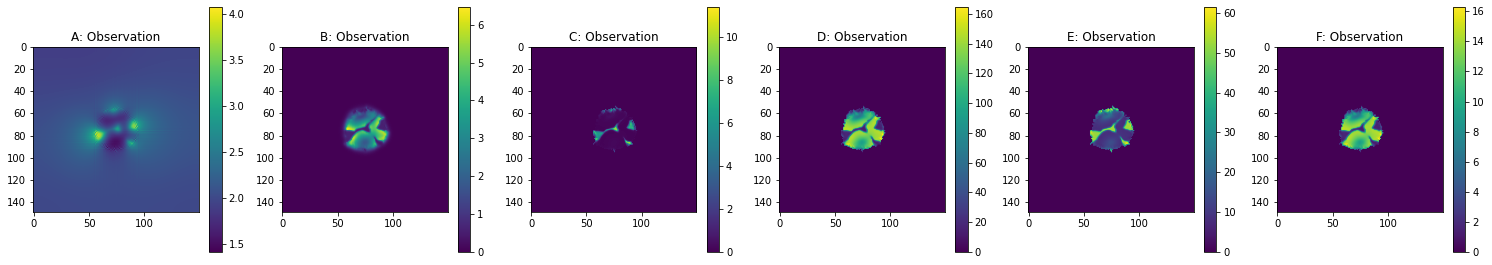

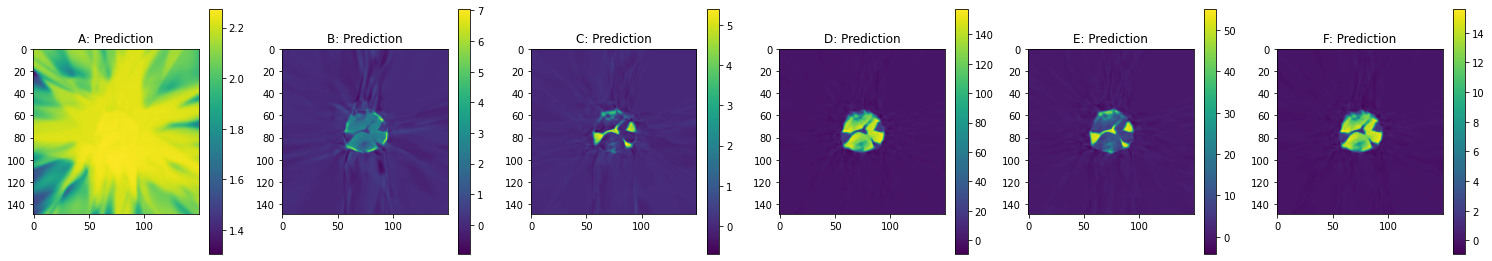

In [33]:
data_original = np.array(ds_1)
_ = plt.figure(figsize=(26,6))
for i, name in enumerate(node_names):
    plt.subplot(1, 6, i+1)
    plt.title(f"{name}: Observation")
    plt.imshow(data_original[i,:, :, T_test_index])
    plt.colorbar(shrink=.75)

plt.show()


_ = plt.figure(figsize=(26,6))
for i, name in enumerate(node_names):
    plt.subplot(1, 6, i+1)
    plt.title(f"{name}: Prediction")
    plt.imshow(output_test[i,:, :])
    plt.colorbar(shrink=.75)

plt.show()

In [34]:
x_domain = L * np.linspace(0, 1, x_size)
y_domain = L * np.linspace(0, 1, y_size)

T_test_index = 119
print(t_star[T_test_index])
X_test, Y_test = np.meshgrid(x_domain, y_domain, sparse=False, indexing="ij")
XX_test = X_test.flatten()  # N x 1
YY_test = Y_test.flatten()  # N x 1
TT_test = np.repeat(t_star[T_test_index], N)  # 1 x N

119


In [35]:
output_test = pinn(np.vstack([XX_test, YY_test, TT_test]).T)
output_test = np.array([ output_test[:, i].numpy().reshape((x_size, y_size)) for i in range(output_test.shape[1])]) 
#for i in range(output_test.shape[0]):
#    output_test[i, :, :] = (output_test[i, :, :] + 1.0)*(maxs[i]-mins[i])/2.0 + mins[i]

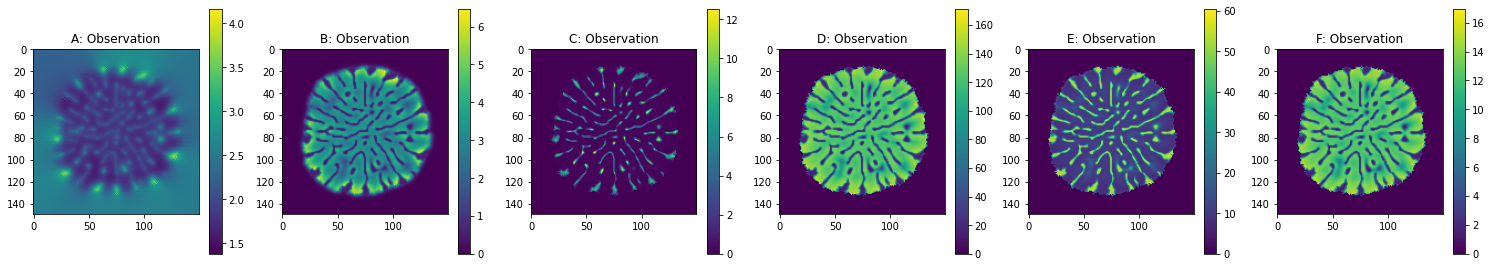

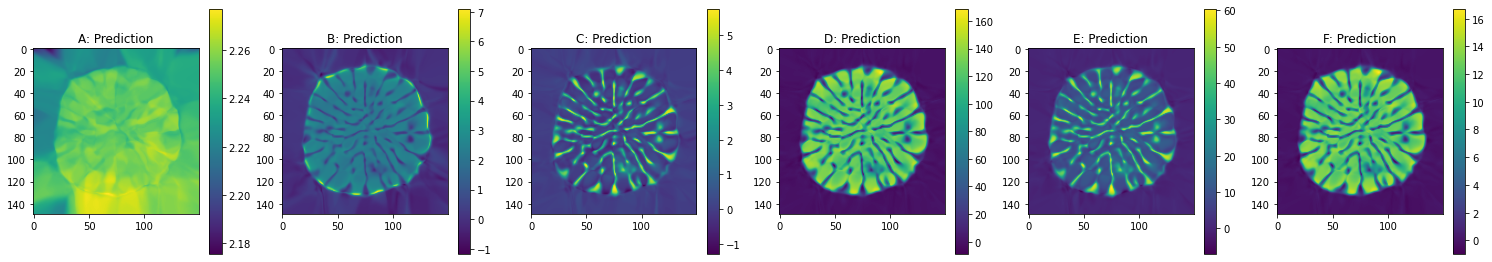

In [36]:
data_original = np.array(ds_1)
_ = plt.figure(figsize=(26,6))
for i, name in enumerate(node_names):
    plt.subplot(1, 6, i+1)
    plt.title(f"{name}: Observation")
    plt.imshow(data_original[i,:, :, T_test_index])
    plt.colorbar(shrink=.75)

plt.show()


_ = plt.figure(figsize=(26,6))
for i, name in enumerate(node_names):
    plt.subplot(1, 6, i+1)
    plt.title(f"{name}: Prediction")
    plt.imshow(output_test[i,:, :])
    plt.colorbar(shrink=.75)

plt.show()